# Overview 

The matrisome is a classification of components of the extracellular matrix. The matrisome can be divided into core matrisome proteins (glycoproteins, collagens, proteoglycans) and matrisome assocaited (affiliated, regulators and secreted factors. More information and the masterlist can be found at http://matrisome.org/. 

This notebook merges all three spatial transcriptomics datasets and corrects batch effects. Next, for each spot, the expression of matrisome divisions is selected. The number is clusters is found using ELBOW and mapped back to the original H&E image. Expression of the top 2 genes per cluster is visualized as a dot plot.

#Installations
Final cell restarts runtime - continue running from imports after 'Your session crashed for an unknown reason'. 

In [1]:
!pip install scanpy
!pip install anndata
!pip install scanorama
!pip install bbknn
!pip install leidenalg
#!pip uninstall xlrd
!pip install xlrd==1.2.0
!pip install leidenalg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 11.2 MB 44.3 MB/s 
     |████████████████████████████████| 88 kB 6.8 MB/s 
     |████████████████████████████████| 96 kB 5.7 MB/s 
     |████████████████████████████████| 960 kB 50.0 MB/s 
     |████████████████████████████████| 1.1 MB 30.9 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=9fb5ccbff53adabd2e49d37c495cc19887694b03923a375134e14c57da1308c1
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=1c4477648a9f902aa3e68da14f8de8616ddca072d8a28b80b7e8ce7ded672a79
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 8.5 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395181 sha256=b77507ce1ca34a485d747f796c49670a5d743217cc76e77d4535bbaeeb8e4c79
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=f485509320b06cc9184af3b138e93533e2129c5df6f3863a8deaa9c37c0fc2d0
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=ac71e09c765d01f362d80c3a2251fc8ecb5dff171aa92400c37cb534df275dab
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/10

In [ ]:
import os
os.kill(os.getpid(), 9)

# Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama
import os
from sklearn.cluster import KMeans
import textwrap
from yellowbrick.cluster import KElbowVisualizer
import os


# Helper functions

In [45]:
from numpy.lib.function_base import percentile


def download_data():
  ''' 
  Downloads:
  1. Human matrisome list 
  2. Three x10 Genomics prostate datasets - Normal, Invasive adenocarcinoma & acinar cellular carcinoma 
  ''' 

  # Matrisome masterlist 
  !wget http://matrisomeproject.mit.edu/static/media/uploads/Files/Human%20in%20silico%20matrisome/matrisome_hs_masterlist.xls

  # Download normal dataset, unzip & place in appropriate folder  
  os.mkdir('Normal')
  !wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Normal_Prostate/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5
  !wget  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Normal_Prostate/Visium_FFPE_Human_Normal_Prostate_spatial.tar.gz
  !tar -xzvf /content/Visium_FFPE_Human_Normal_Prostate_spatial.tar.gz
  os.replace('spatial', 'Normal/spatial')

  # Download invasive adenocarcinoma dataset 
  os.mkdir('IAC')
  !wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Cancer/Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5  
  !wget  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Cancer/Visium_FFPE_Human_Prostate_Cancer_spatial.tar.gz
  !tar -xzvf /content/Visium_FFPE_Human_Prostate_Cancer_spatial.tar.gz
  os.replace('spatial', 'IAC/spatial')
  

  # Download acinar cellular carcinoma dataset 
  os.mkdir('ACC')
  !wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_filtered_feature_bc_matrix.h5
  !wget  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_spatial.tar.gz
  !tar -xzvf /content/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_spatial.tar.gz
  os.replace('spatial', 'ACC/spatial')

  print('\n - - - - - - - - - - - ')
  print('\nDownloads complete')
  print(' - - - - - - - - - - - ')
  return 

def set_figure_dir(name): 
  name = name+'_figures'
  os.mkdir(name)
  sc.settings.figdir ='/content/' + name +'/'
  print('Image results will be saved in' , name, 'folder')
  return 

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
  

def plot_ranked_genes_per_cluster(adata, savename, c):
  # k means 
  X = adata.X.toarray()
  opt_k = find_k_elbow(X)
  km = KMeans(n_clusters=opt_k, random_state=0).fit(X) 
  adata.obs['kmeans'] = km.labels_.astype(str)

  # Plot ranks  
  sc.tl.rank_genes_groups(adata, 'kmeans', method='t-test')
  sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = '_'+ savename)
  sc.pl.rank_genes_groups_dotplot(adata,n_genes=2, dendrogram = False, save = '_'+ savename, cmap = c)

  return 


def filter_matrisome(category): 
  '''
  Filters matrisome genes within ST dataset 
  '''
  # Download matrisome list
  #matrisome_list = pd.read_excel('/content/drive/MyDrive/Studies_Work/PhD_WT_IMC/Spatial transcriptomics/matrisome_hs_masterlist.xls')
  matrisome_list = pd.read_excel('/content/matrisome_hs_masterlist.xls')


  valid_categories = ['Collagens',
                      'ECM Glycoproteins',
                      'Proteoglycans',
                      'ECM-affiliated Proteins',
                      'ECM Regulators',
                      'Secreted Factors']

  if category not in valid_categories:
    print('Incorrect category, select from: ', valid_categories)
  coll_mask = matrisome_list['Category'] == category
  matrisome_genes = matrisome_list['Gene Symbol'][coll_mask].to_list()
  var_df = sc.get.var_df(adata)
  vis_genes = var_df.index.to_list()
  mat_cis_intersect = intersection(vis_genes, matrisome_genes)
  mask = [vg in mat_cis_intersect for vg in vis_genes]
  adata_category = adata[:, mask]
  return adata_category

def calculate_percentage_cluster(labels):
  percentages = [] 
  n_labels = np.unique(labels)
  for i in n_labels:
    mask = labels == i 
    sum_m = len(labels[mask].astype(float))
    p = sum_m / len(labels.astype(float))
    percentages.append(p)
  return np.round(percentages,2)



def merge_adatas(files_locations, dataset_names): 
  adata_dict = {}

  for i in range(len(dataset_names)):
    adata_dict[dataset_names[i]] = load_data(files_locations[i][0], files_locations[i][1])
    adata_dict[dataset_names[i]].var_names_make_unique()

  batch_id = ['Normal', 'Invasive adenocarcinoma', 'Acinar cellulcar carcinoma']

  adata = adata_dict['Norm'].concatenate(
      (adata_dict['IAC'], adata_dict['ACC']),
      batch_key='batch_id',
      uns_merge="unique",
      batch_categories=batch_id
  )

  return adata, adata_dict


def map_kms_to_hires_image(adata): 
  km_labels = np.array(adata.obs['kmeans'].values)
  
  norm_len = adata_dict['Norm'].shape[0]
  norm_km_y = km_labels[:norm_len]

  IAC_len = adata_dict['IAC'].shape[0]
  IAC_km_y = km_labels[norm_len:(norm_len+IAC_len)]

  ACC_len = adata_dict['ACC'].shape[0]
  ACC_km_y = km_labels[(norm_len+IAC_len):]

  km_ys = [norm_km_y, IAC_km_y, ACC_km_y]

  for i in range(len(dataset_names)): 
    adata_dict[dataset_names[i]].obs['kmeans'] = km_ys[i]
  return adata_dict

def plot_hires_km(adata_dict, palette_key,savename):
  keys = ['Norm', 'IAC', 'ACC']
  for i,k in enumerate(keys): 
    fig, ax = plt.subplots(1,2)
    sc.pl.spatial(adata_dict[k], ax=ax[0], show=False)
    sc.pl.spatial(adata_dict[k], img_key="hires", color="kmeans",  palette =palette_key, ax=ax[1], show=False, title=None, save='_' + savename+'_'+k+'.png')

  return 

def calc_all_percentages():
    keys = ['Norm', 'IAC', 'ACC']
    all_p = []
    for k in keys: 
      p = calculate_percentage_cluster(adata_dict[k].obs['kmeans'])
      all_p.append(p)
    df = pd.Dataframe((all_p), index=keys)
    return df.transpose()

def plot_hbar(top5_go_terms, savename, c, xt): 
  counts = top5_go_terms['Counts']
  go_terms = top5_go_terms['Term']
  ax = sns.barplot(x=counts, y=go_terms, color=c)
  ax.set_yticklabels([textwrap.fill(e,22) for e in go_terms])
  plt.xticks(range(1,xt))

  plt.savefig(savename)
  return 

def remove_GO_id(term): 
  characters =  np.array([char for char in term])
  idx = np.argwhere(characters == '[')[0][0]
  term_no_id = term[:idx-1]
  return term_no_id

def calc_all_percentages(adata_dict):
    keys = ['Norm', 'IAC', 'ACC']
    all_p = []
    for k in keys: 
      p = calculate_percentage_cluster(adata_dict[k].obs['kmeans'])
      all_p.append(p)
      print(k)
      print(all_p)
      print('----')
    df = pd.DataFrame((all_p), index=keys)
    return df

def generate_unique_GO(all_go_terms):
  # Create single list of GO terms  
  single_list = []
  for row in range(len(all_go_terms)):
    for element in range(len(all_go_terms[row])): 
      single_list.append(remove_GO_id(all_go_terms[row][element]))

  # Make unique, count and create dataframe 
  go_terms, go_counts = np.unique(single_list, return_counts=True)
  df = pd.DataFrame((go_terms, go_counts), index=['Term', 'Counts']).transpose()
  return df.sort_values(by='Counts', ascending=False)


def plot_GO(top_gene_go_terms, savename, c):
  mr_all_terms = top_gene_go_terms['Gene ontology (biological process)'].str.split(';')
  go_norm_term_df = generate_unique_GO(mr_all_terms)
  top5_norm_go = go_norm_term_df.head(5)
  plot_hbar(top5_norm_go, savename, c, 4)
  return 
  
def find_k_elbow(X):
  model = KElbowVisualizer(KMeans(), k=10)
  model.fit(X)
  model.show()
  return model.elbow_value_

def load_data(pf, cf):
  adata = sc.read_visium(pf, genome=None, count_file=cf, library_id=None, load_images=True,
                           source_image_path=None)
  return adata

def count_labels(adata):
  '''
  Counts malignant and cluster labels 
  '''

  # Load labels from classifier 
  maligancy_labels = adata.obs['malignancy_labels'].values

  # Cluster labels 
  #adata_iac = adata.obs[adata.obs['batch_id'] == 'Invasive adenocarcinoma']
  labels = adata.obs['kmeans'].values

  # Contingency table with collagen clusters relative to predicted malignat spots in IAC
  malig_table = pd.crosstab(maligancy_labels, labels)
  #malig_table.columns = ['Col cluster 0', ' Col cluster 1', 'Col cluster 2', 'Col cluster 3']
  malig_table.index = ['Non-maligant', 'Malignant']
  return  malig_table

In [4]:
# Uncomment to set images to higher resolution 
#sc.set_figure_params(dpi=300, dpi_save=300, fontsize=10)

# Download data

Downloads human matrisome masterlist and three prostate spatial transcriptomics datasets -  a normal, invasive adenocarcinoma  and acinar cellular carcinoma. 

For more information about the spatial transcriptomic datasets or matrisome list, please click the links below: 

[Human matrisome](http://matrisome.org/)

[Normal](https://www.10xgenomics.com/resources/datasets/normal-human-prostate-ffpe-1-standard-1-3-0) 

[Invasive adenocarcinoma](https://www.10xgenomics.com/resources/datasets/human-prostate-cancer-adenocarcinoma-with-invasive-carcinoma-ffpe-1-standard-1-3-0) 

[Acinar cellular carcinoma ](https://www.10xgenomics.com/resources/datasets/human-prostate-cancer-acinar-cell-carcinoma-ffpe-1-standard)



In [5]:
download_data()

--2022-10-13 12:44:22--  http://matrisomeproject.mit.edu/static/media/uploads/Files/Human%20in%20silico%20matrisome/matrisome_hs_masterlist.xls
Resolving matrisomeproject.mit.edu (matrisomeproject.mit.edu)... 18.18.159.13
Connecting to matrisomeproject.mit.edu (matrisomeproject.mit.edu)|18.18.159.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378880 (370K) [application/vnd.ms-excel]
Saving to: ‘matrisome_hs_masterlist.xls’

matrisome_hs_master 100%[===================>] 370.00K  --.-KB/s    in 0.1s    

2022-10-13 12:44:22 (2.78 MB/s) - ‘matrisome_hs_masterlist.xls’ saved [378880/378880]

--2022-10-13 12:44:23--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Normal_Prostate/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP re

# Preprocessing

## Load and merge datasets

In [11]:
# Set paths to spatial folder + matrix

# Normal paths 
pf_norm = '/content/Normal'
cf_nom = '/content/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5'

# Invasive adenocarcinoma paths 
pf_iac = '/content/IAC'
cf_iac = '/content/Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5'

pf_acc = '/content/ACC'
cf_acc = '/content/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_filtered_feature_bc_matrix.h5'

files_locations = [[pf_norm, cf_nom], [pf_iac, cf_iac], [pf_acc, cf_acc]]


Load annotated data from 4 prostate spatial transcriptomics datasets 

In [12]:
dataset_names = ['Norm', 'IAC', 'ACC']
adata, adata_dict = merge_adatas(files_locations, dataset_names)

## Quality control & Normalization

In [14]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

# Normalize data
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

#cells after MT filter: 9957


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


## Visualizing batch effect

         Falling back to preprocessing with `sc.pp.pca` and default params.


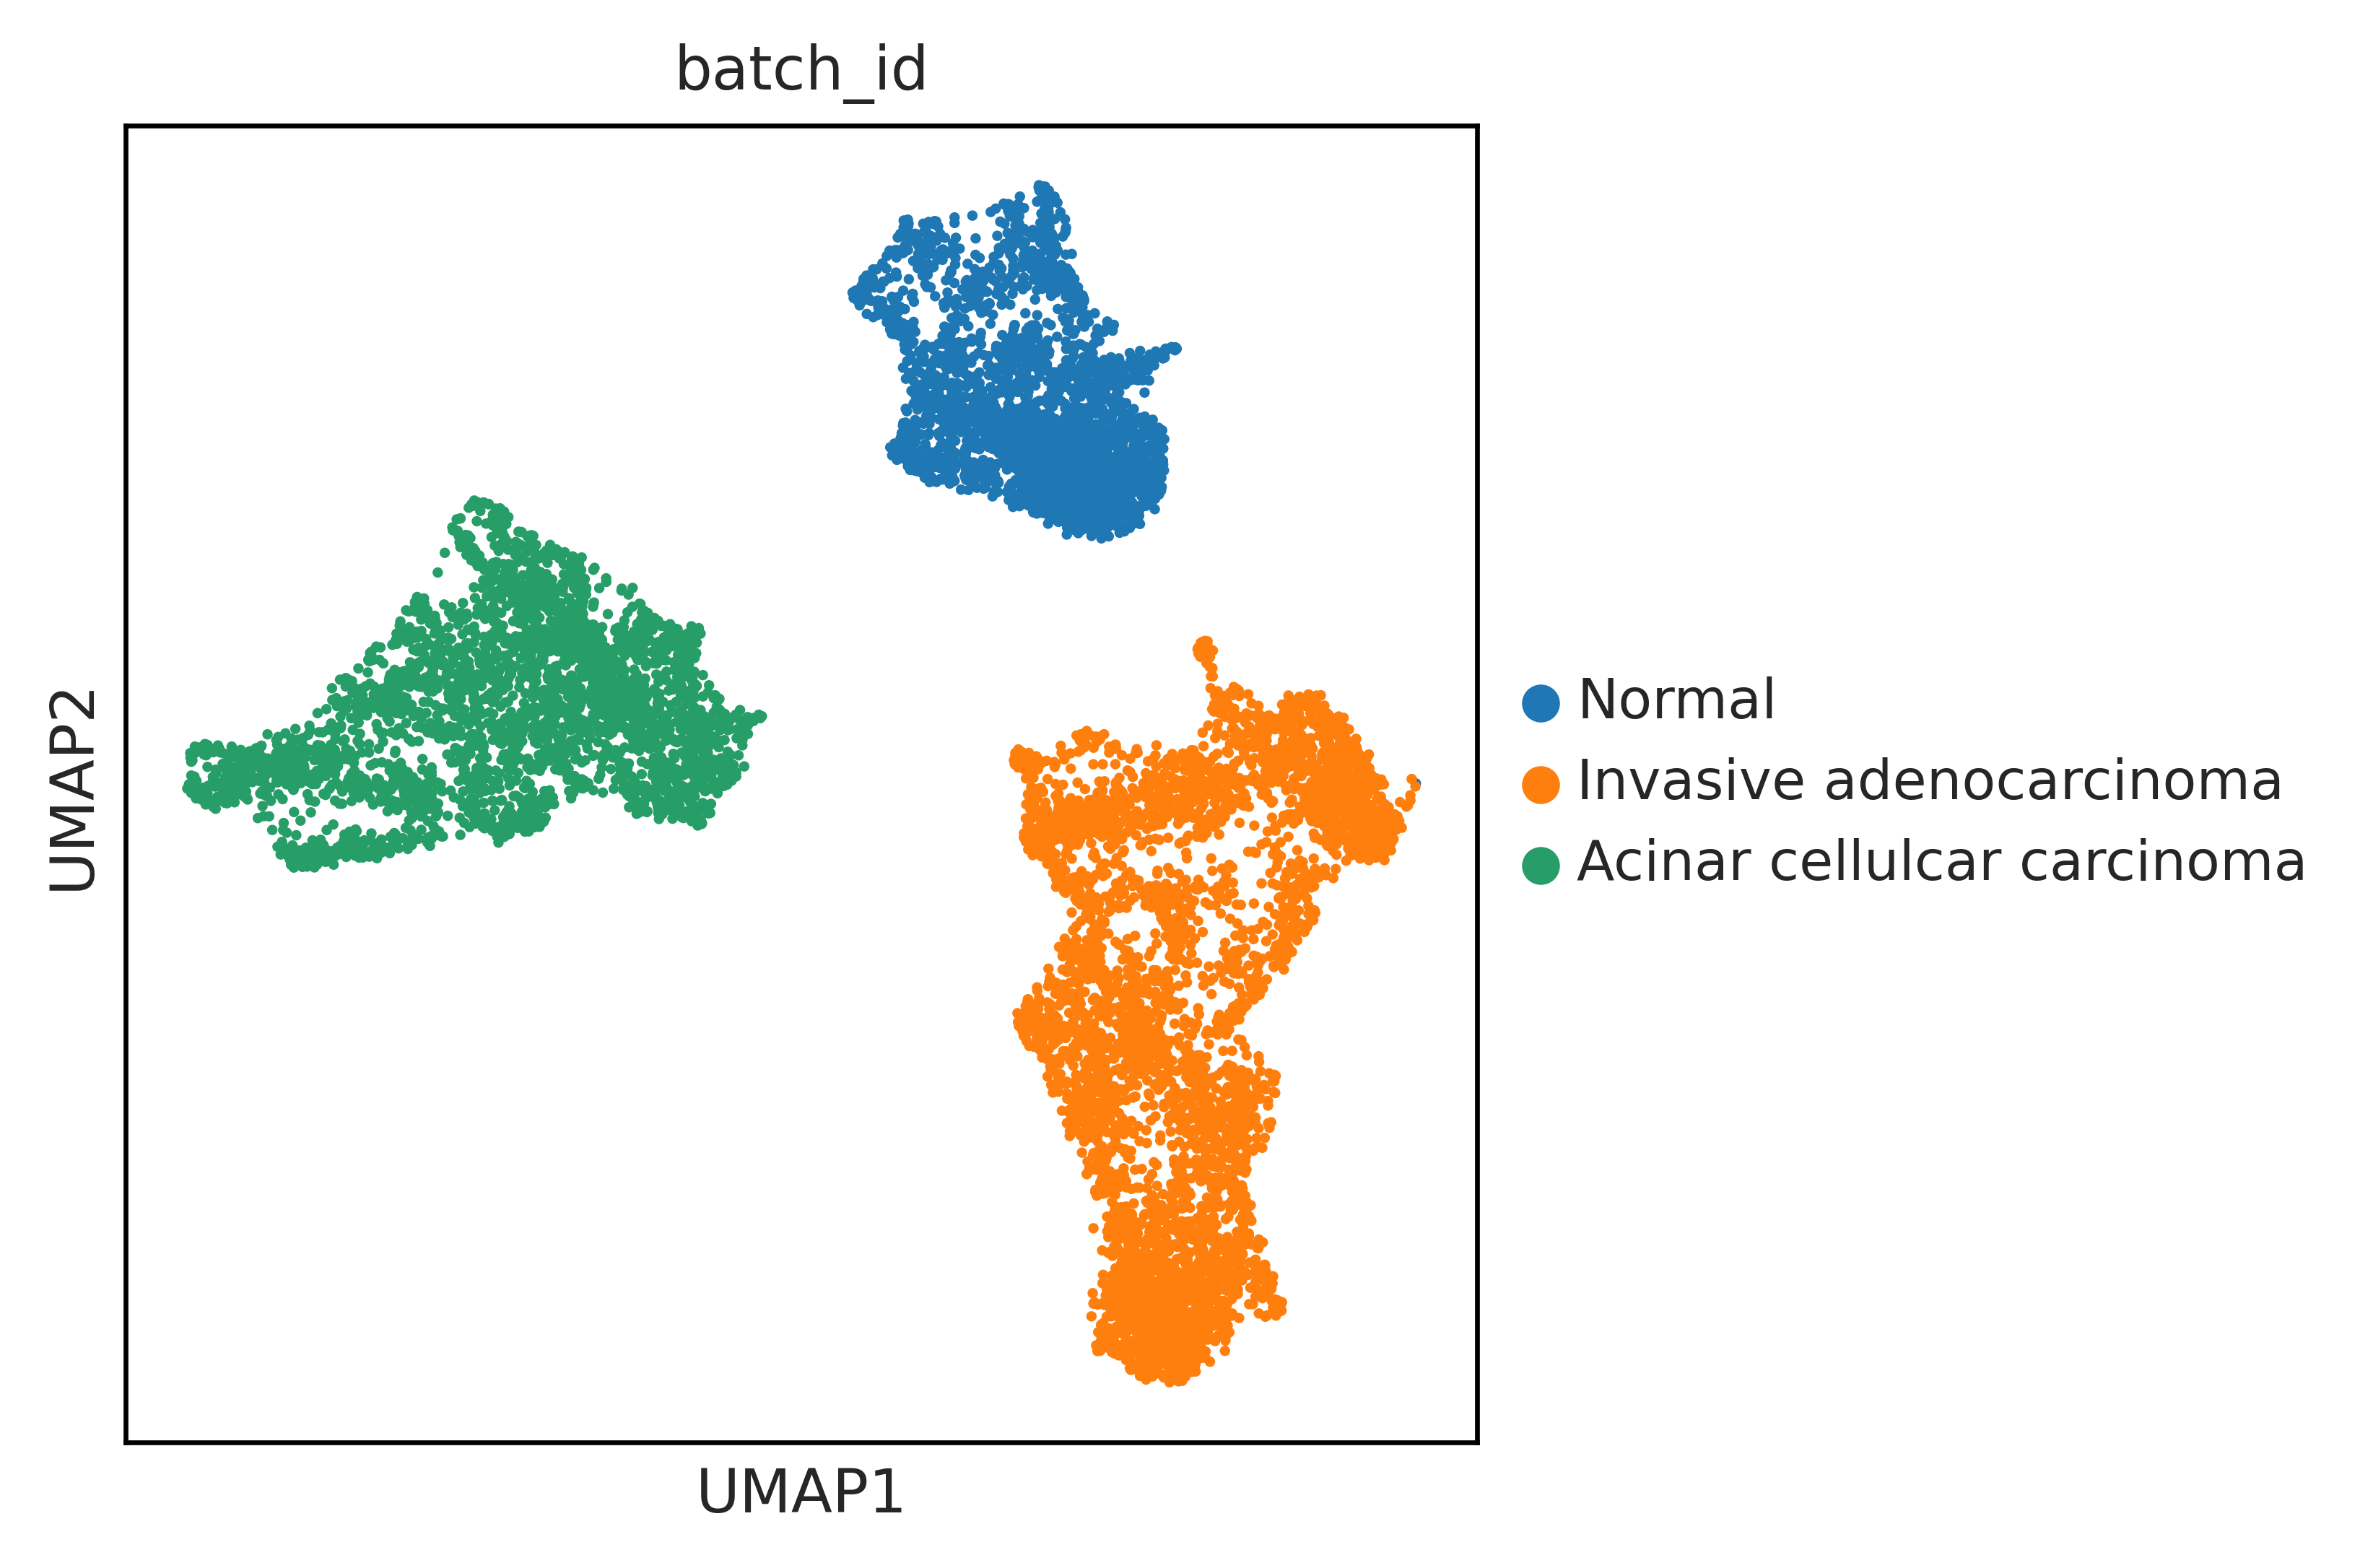

In [15]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch_id'],save= 'batch_effect.png')

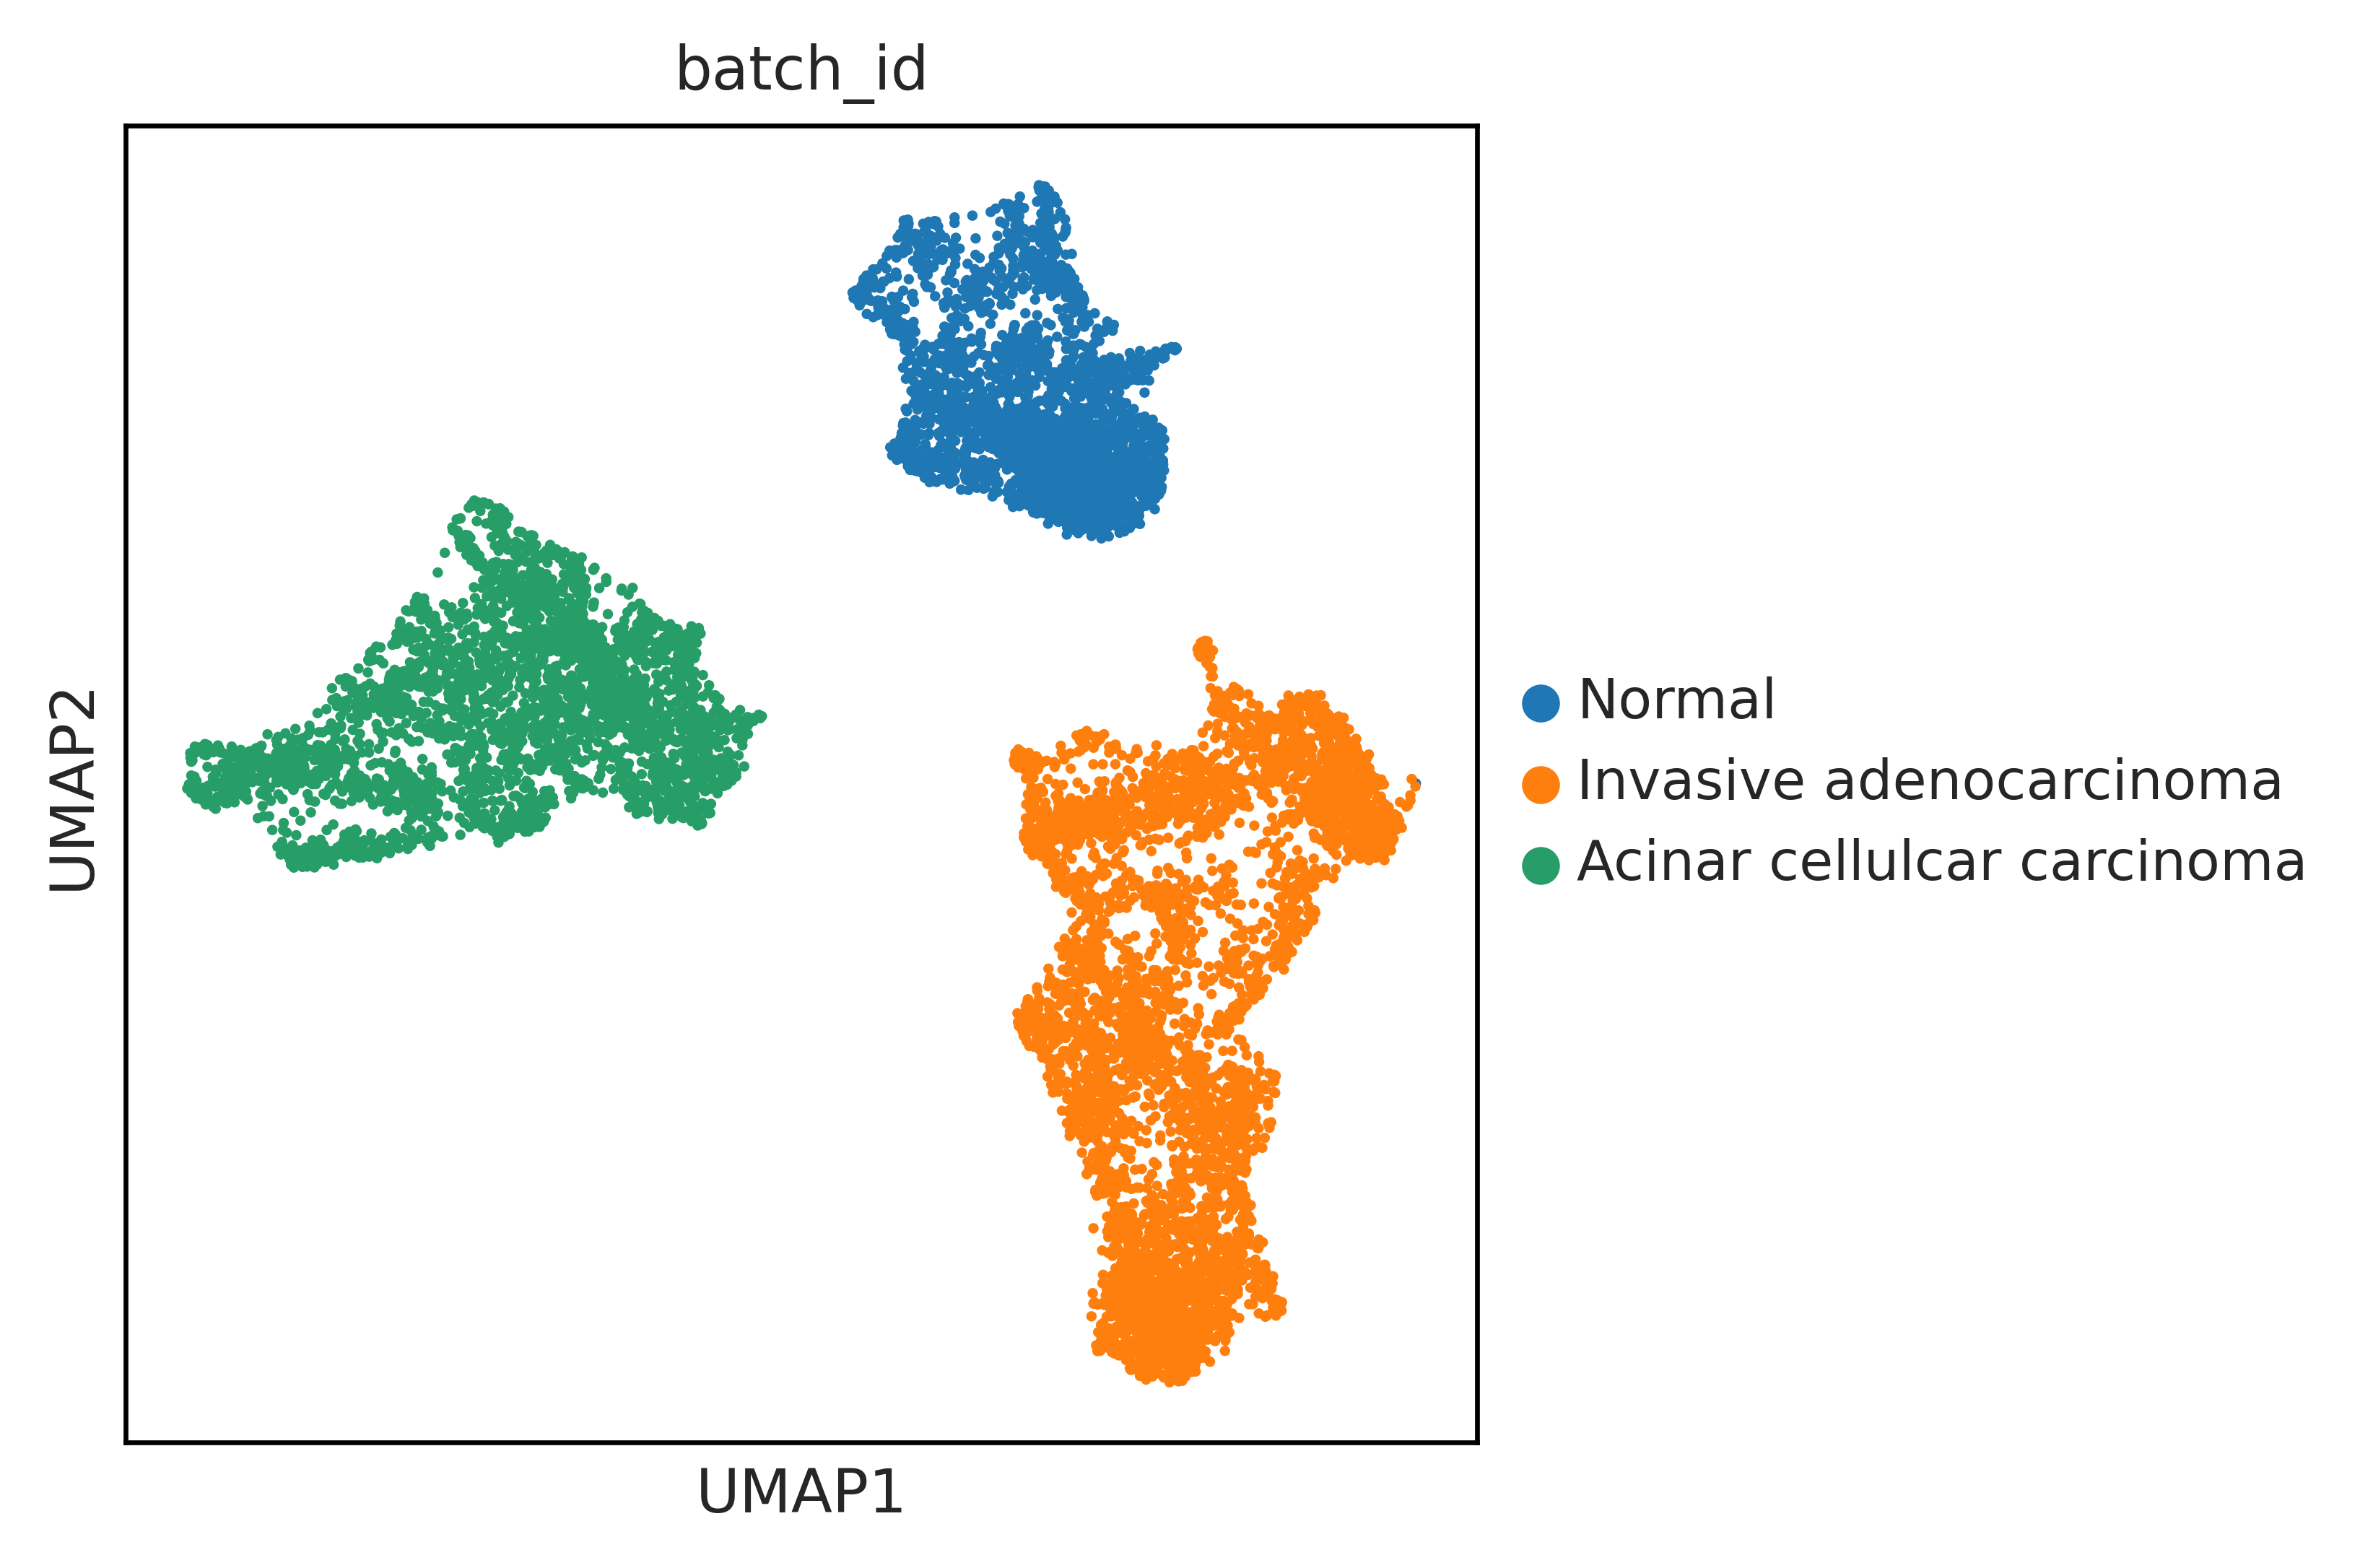

In [16]:
sc.pl.umap(adata, color=['batch_id'],save= 'batch_effect.png')

## Batch control - bbknn

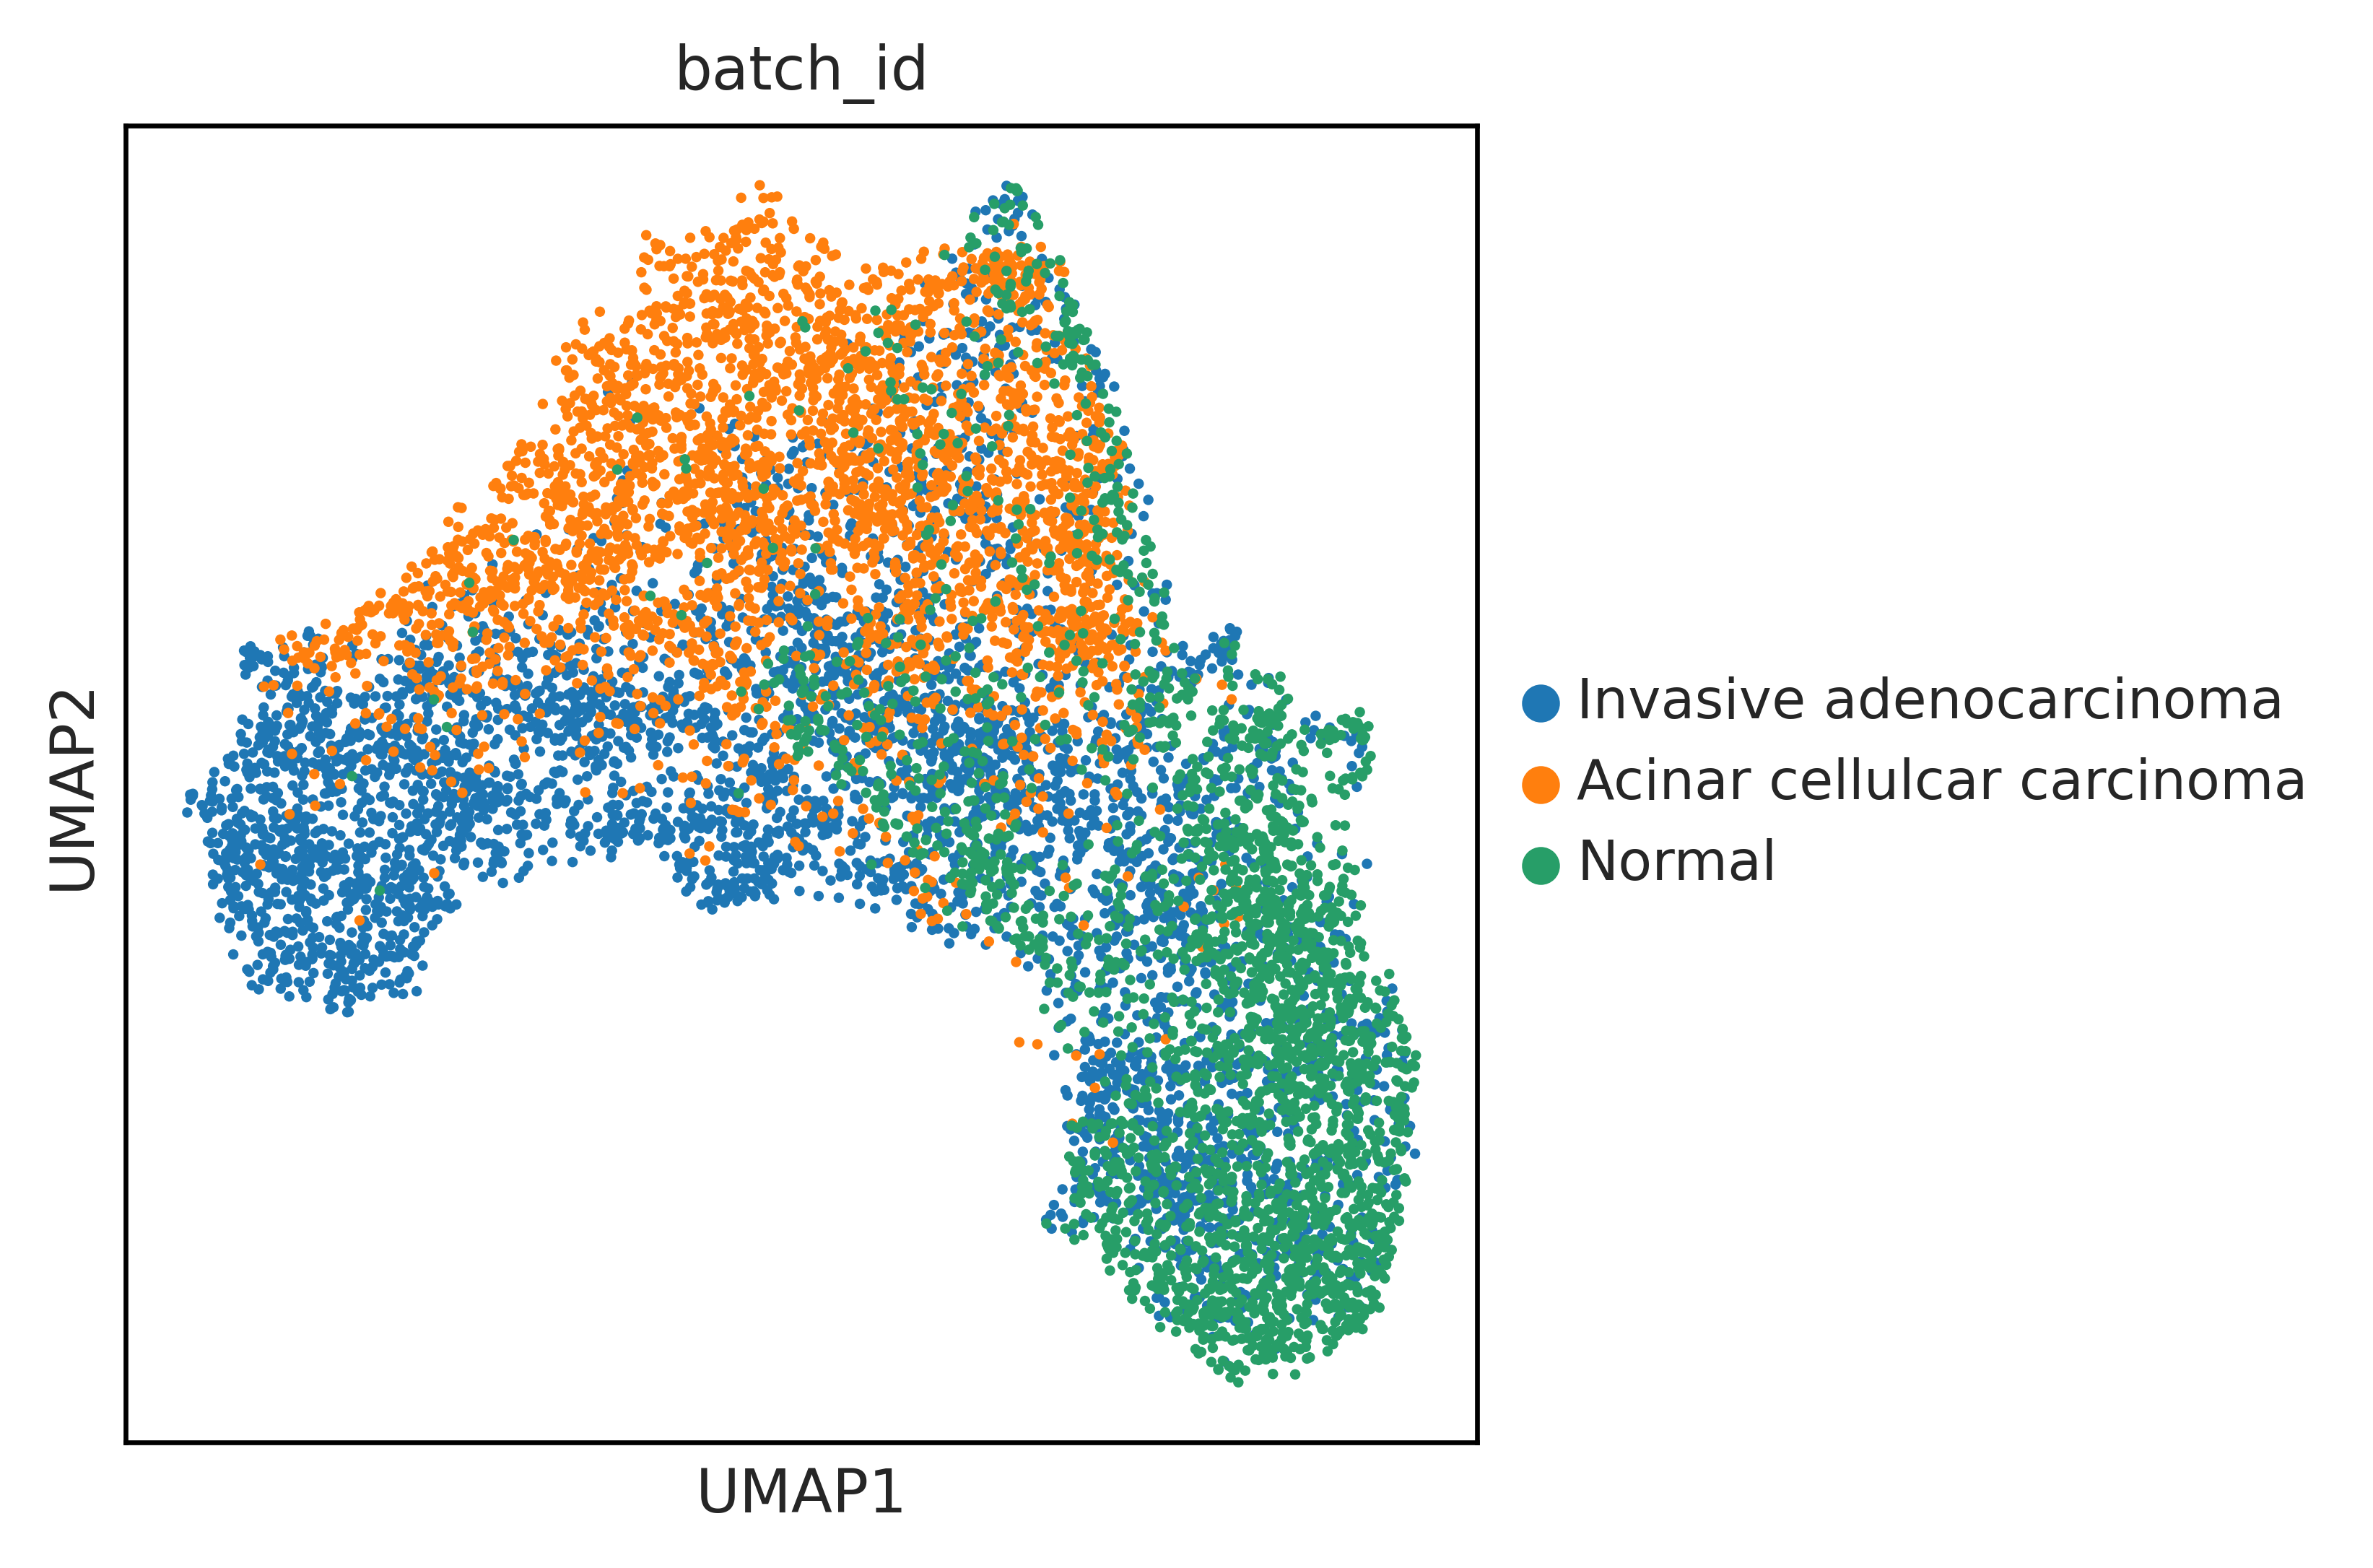

In [ ]:
sc.external.pp.bbknn(adata, batch_key='batch_id') 
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch_id'], save='_corrected_be.png')

# Collagen 
Image results saved in 'Collagens_figures' folder


In [26]:
set_figure_dir('Collagens')

Image results saved in collagen_figures folder


In [33]:
adata_collagens = filter_matrisome('Collagens')

In [34]:
adata_collagens

View of AnnData object with n_obs × n_vars = 9957 × 43
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'neighbors', 'umap', 'batch_id_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
plot_ranked_genes_per_cluster(adata_collagens, 'collagen.png', 'RdYlBu')

In [36]:
adata_dict = map_kms_to_hires_image(adata_collagens)

In [37]:
plot_hires_km(adata_dict, 'RdYlBu', 'collagens')

In [ ]:
# Proportions per dataset, manually created into stacked barchart 
p_df = calc_all_percentages(adata_dict)
p_df.to_excel('coll_percentages.xlsx')

## Save kmean labels for later analysis

In [39]:
# Save km labels for later analysis
adata_dict['Norm'].obs.to_excel('norm_km_labels.xlsx')
adata_dict['IAC'].obs.to_excel('iac_km_labels.xlsx')
adata_dict['ACC'].obs.to_excel('aac_km_labels.xlsx')


# Glycoproteins  
Image results will be saved in 'Glycoproteins_figures' folder

In [44]:
set_figure_dir('Glycoproteins')

FileExistsError: ignored

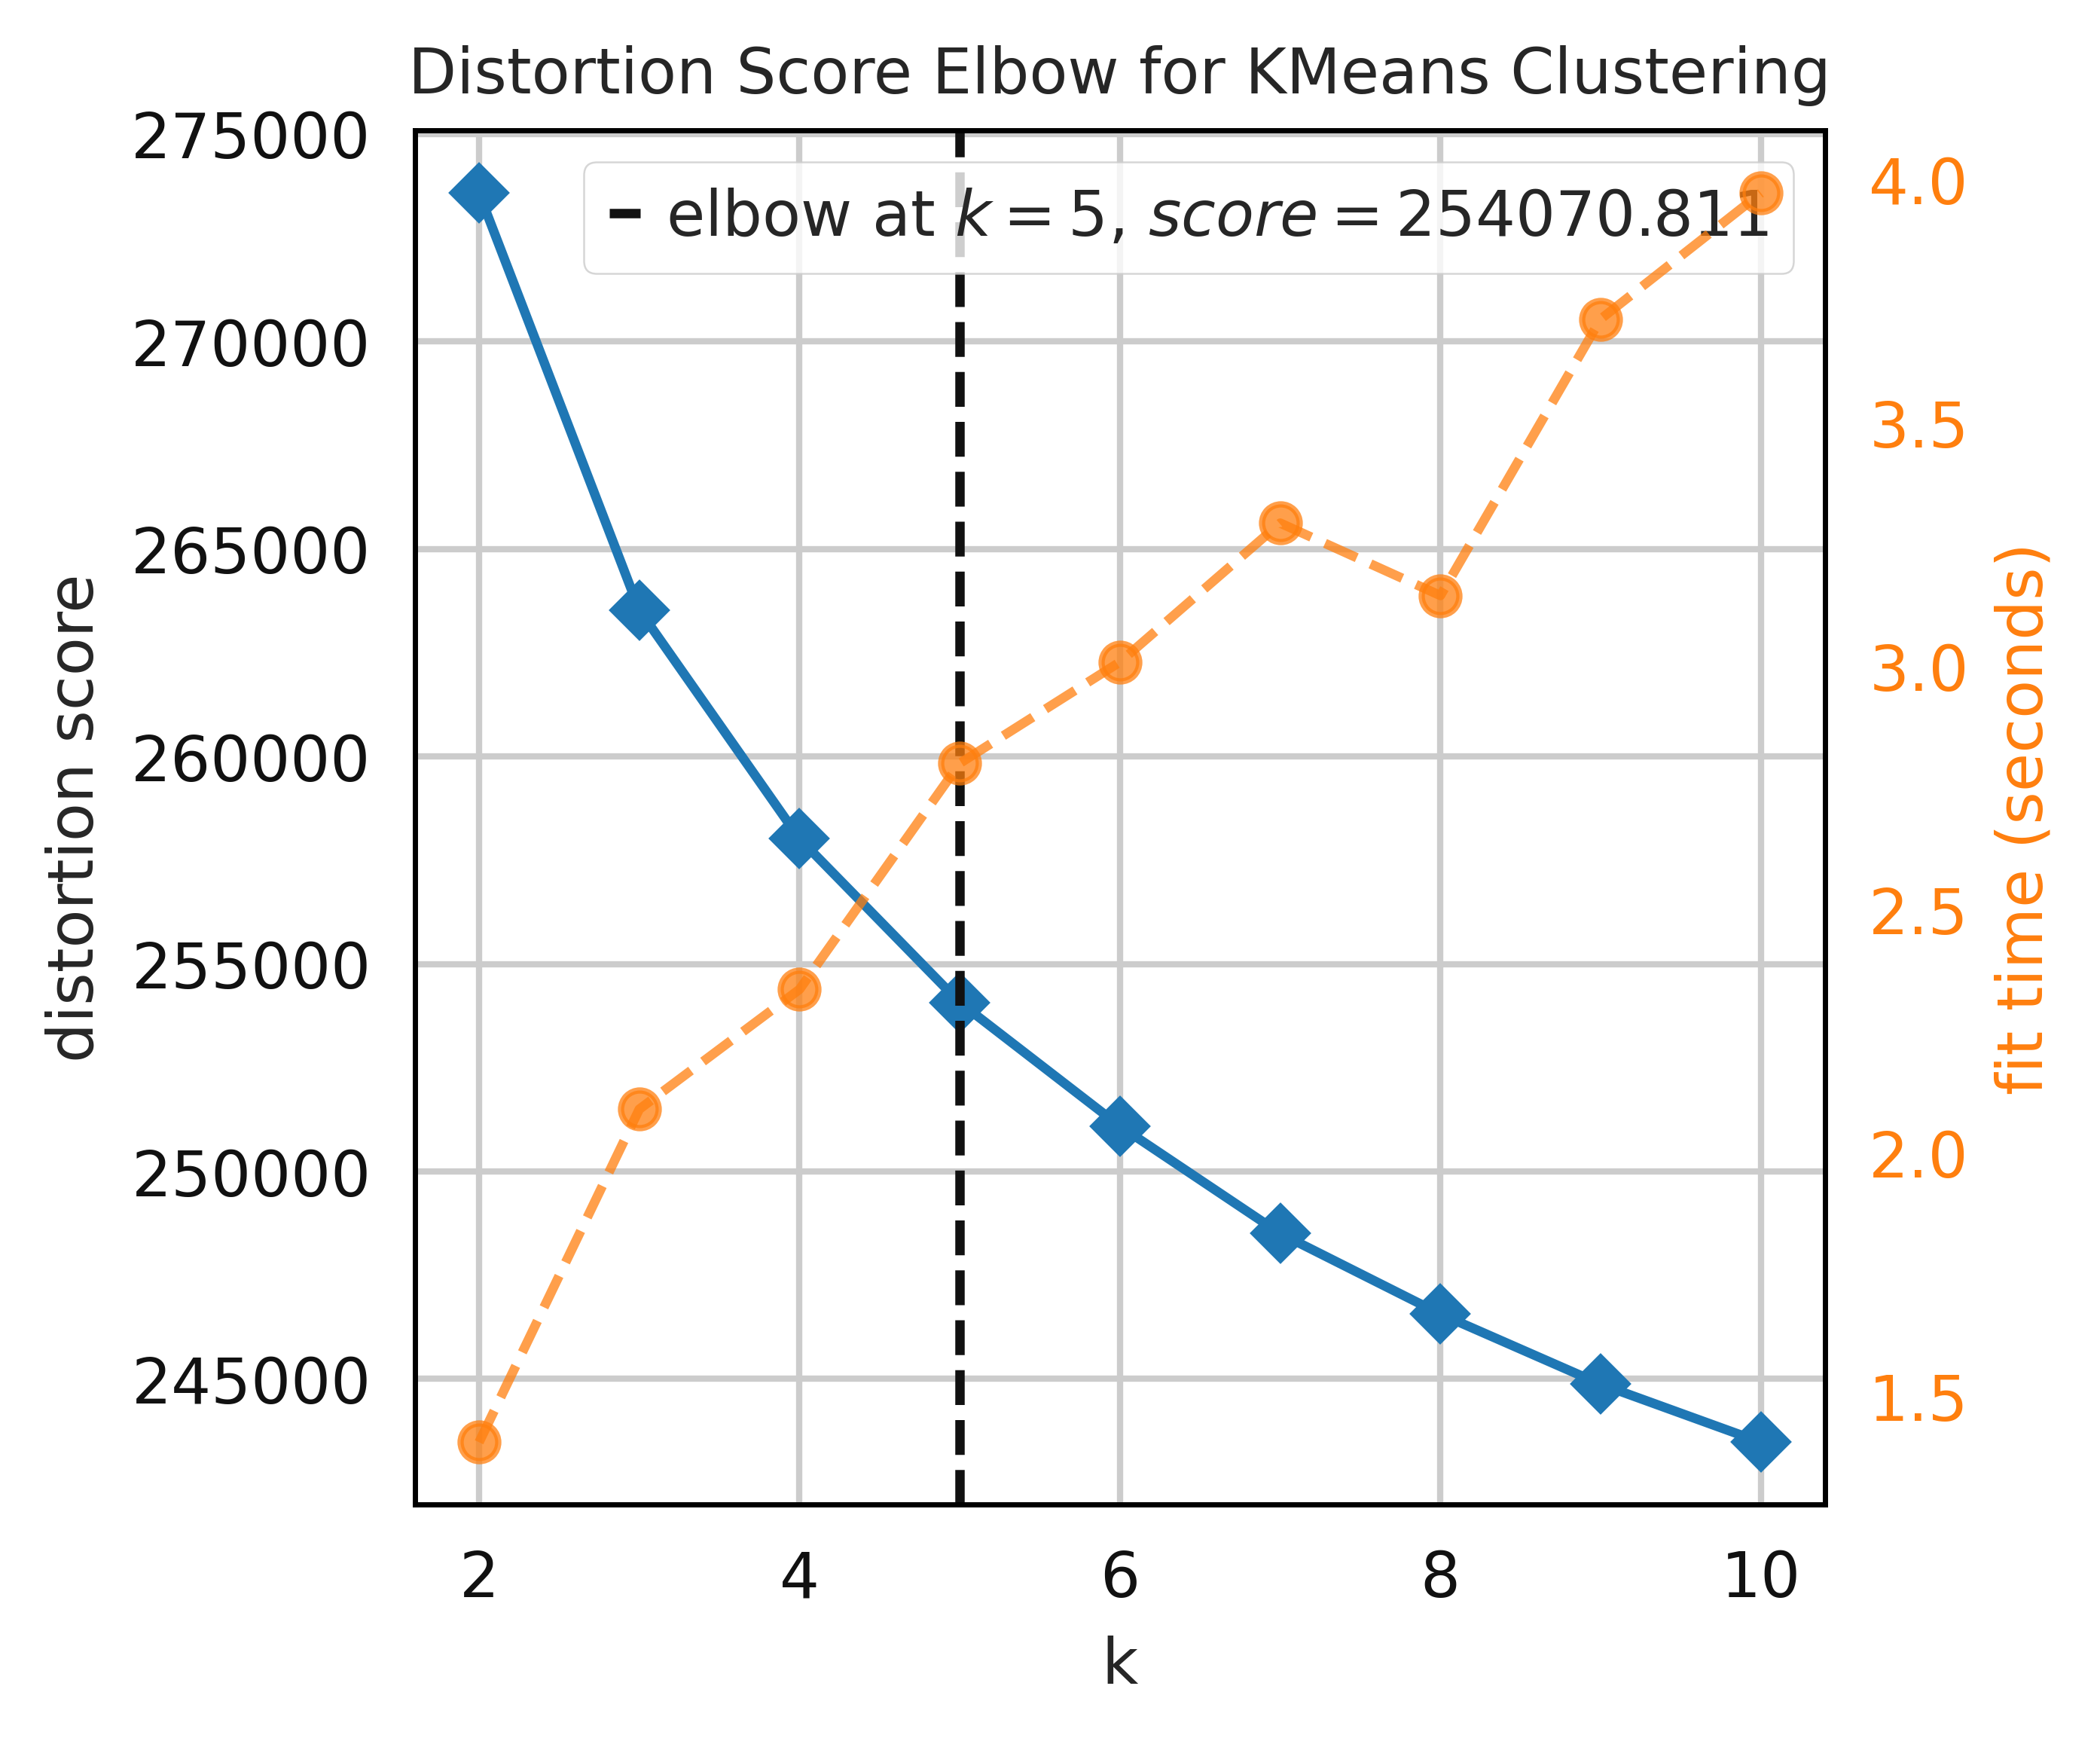

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if sys.path[0] == '':


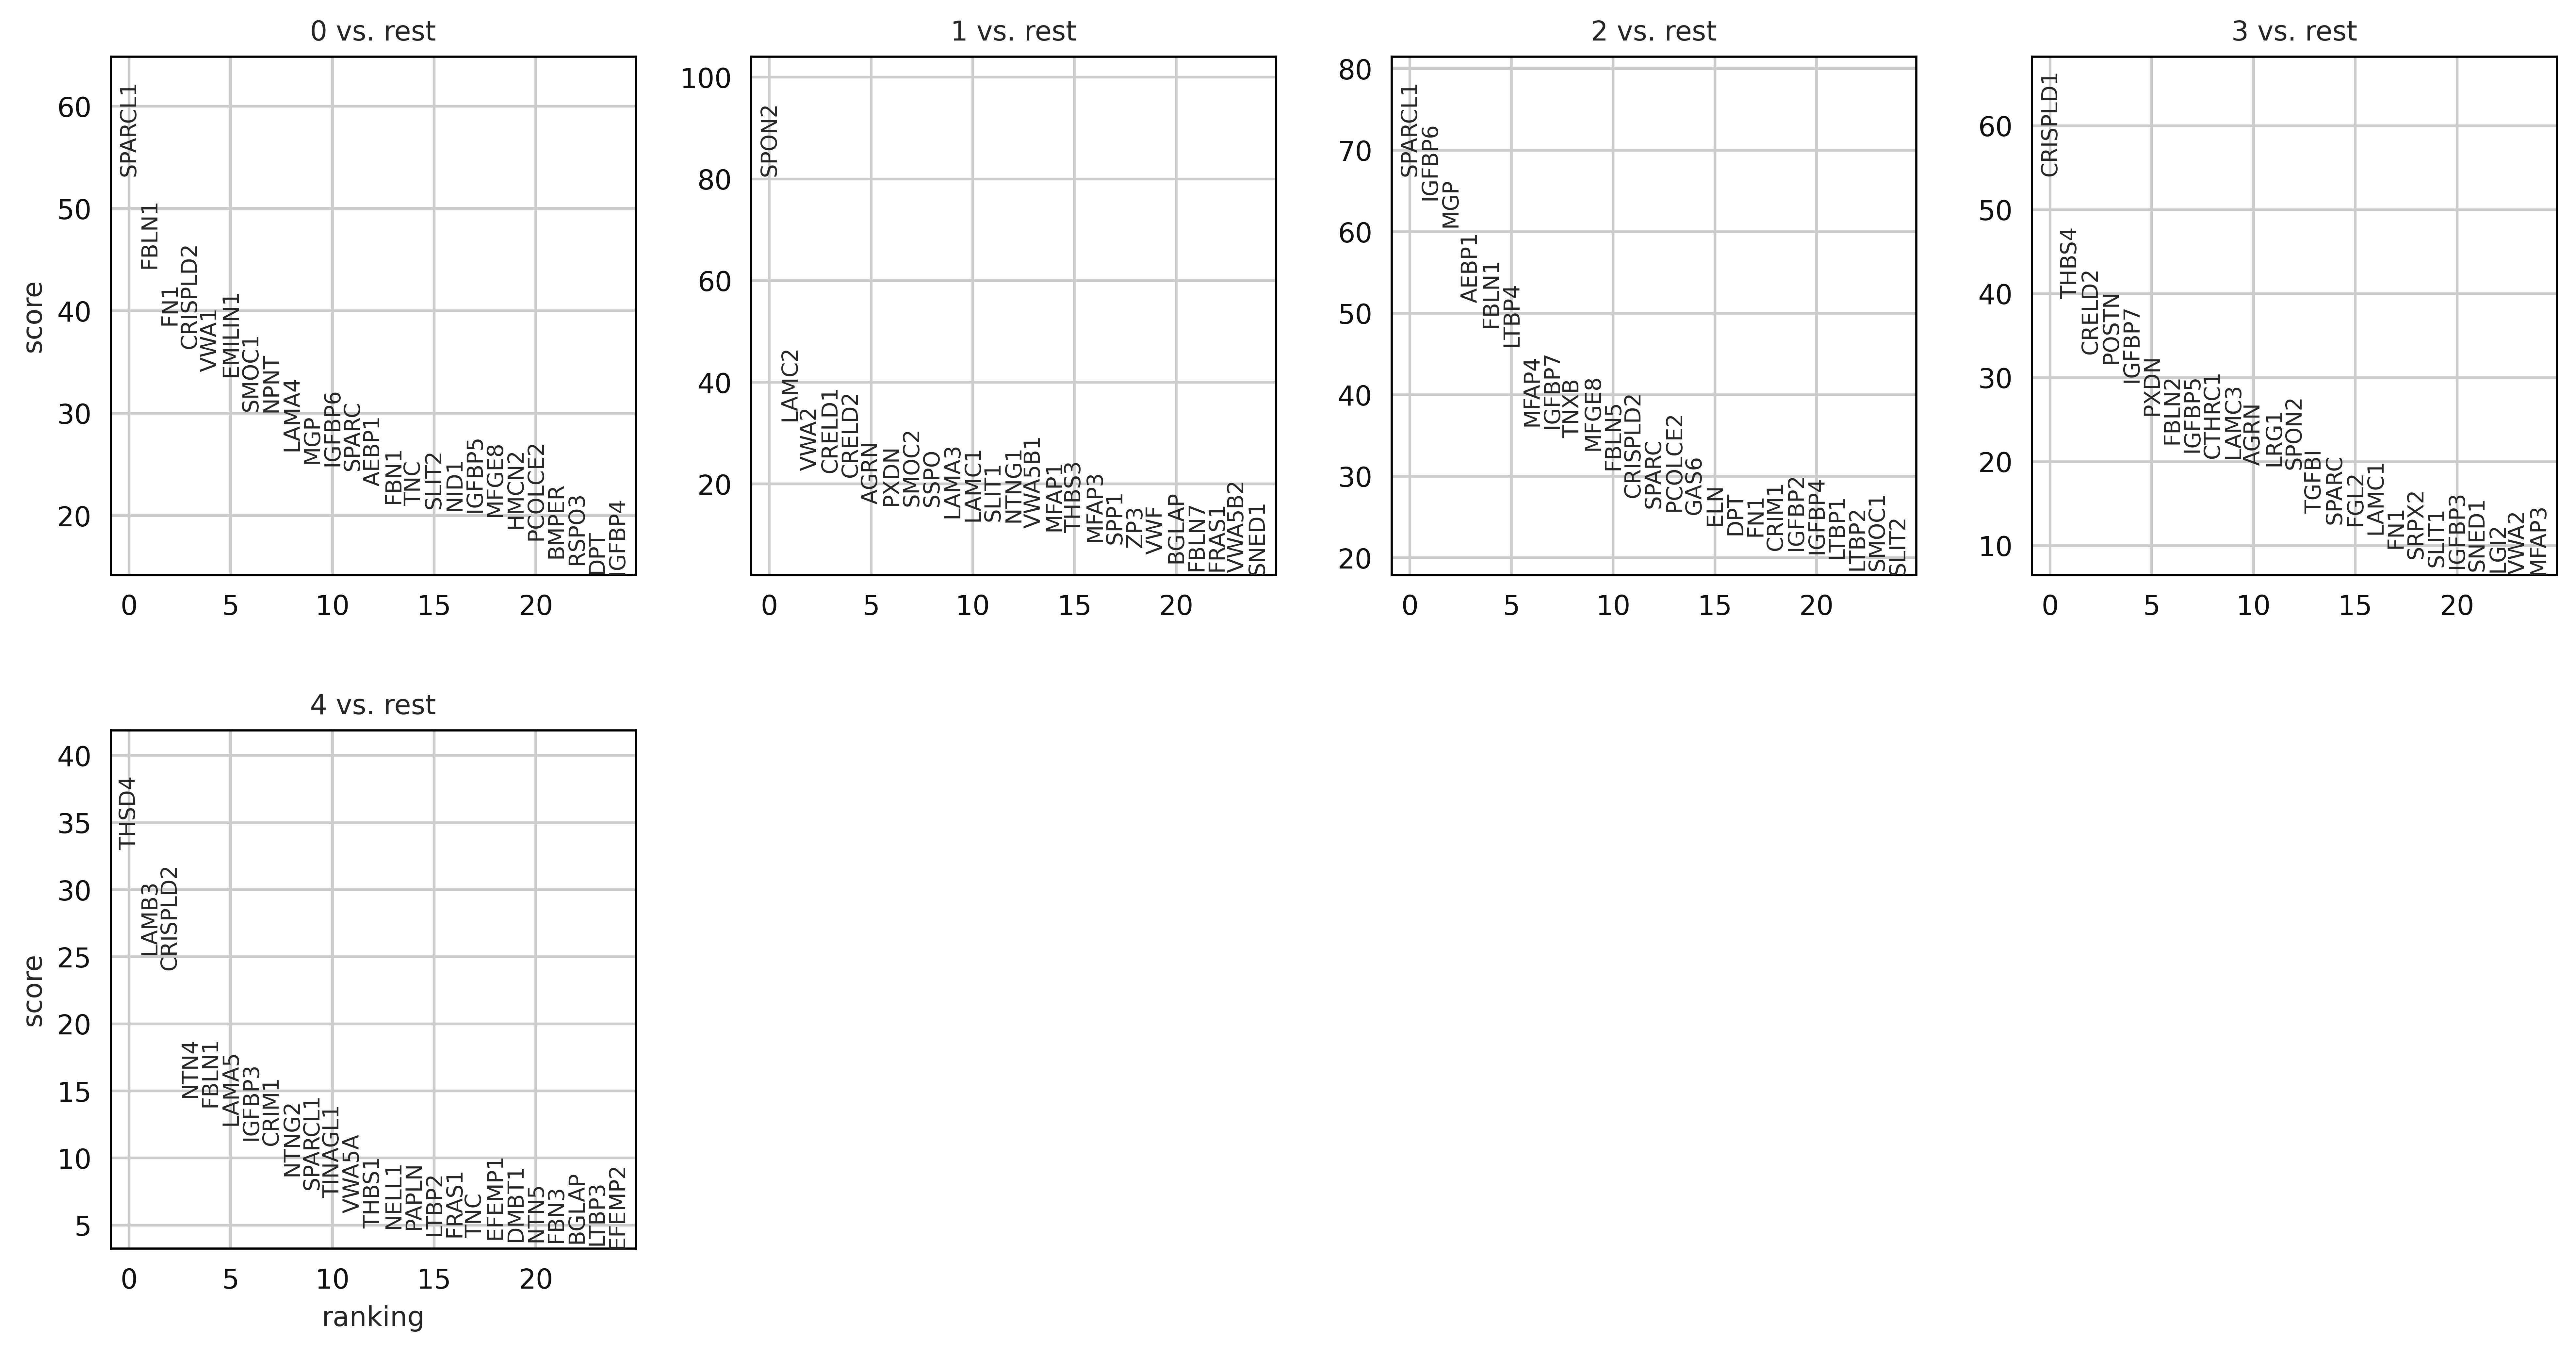

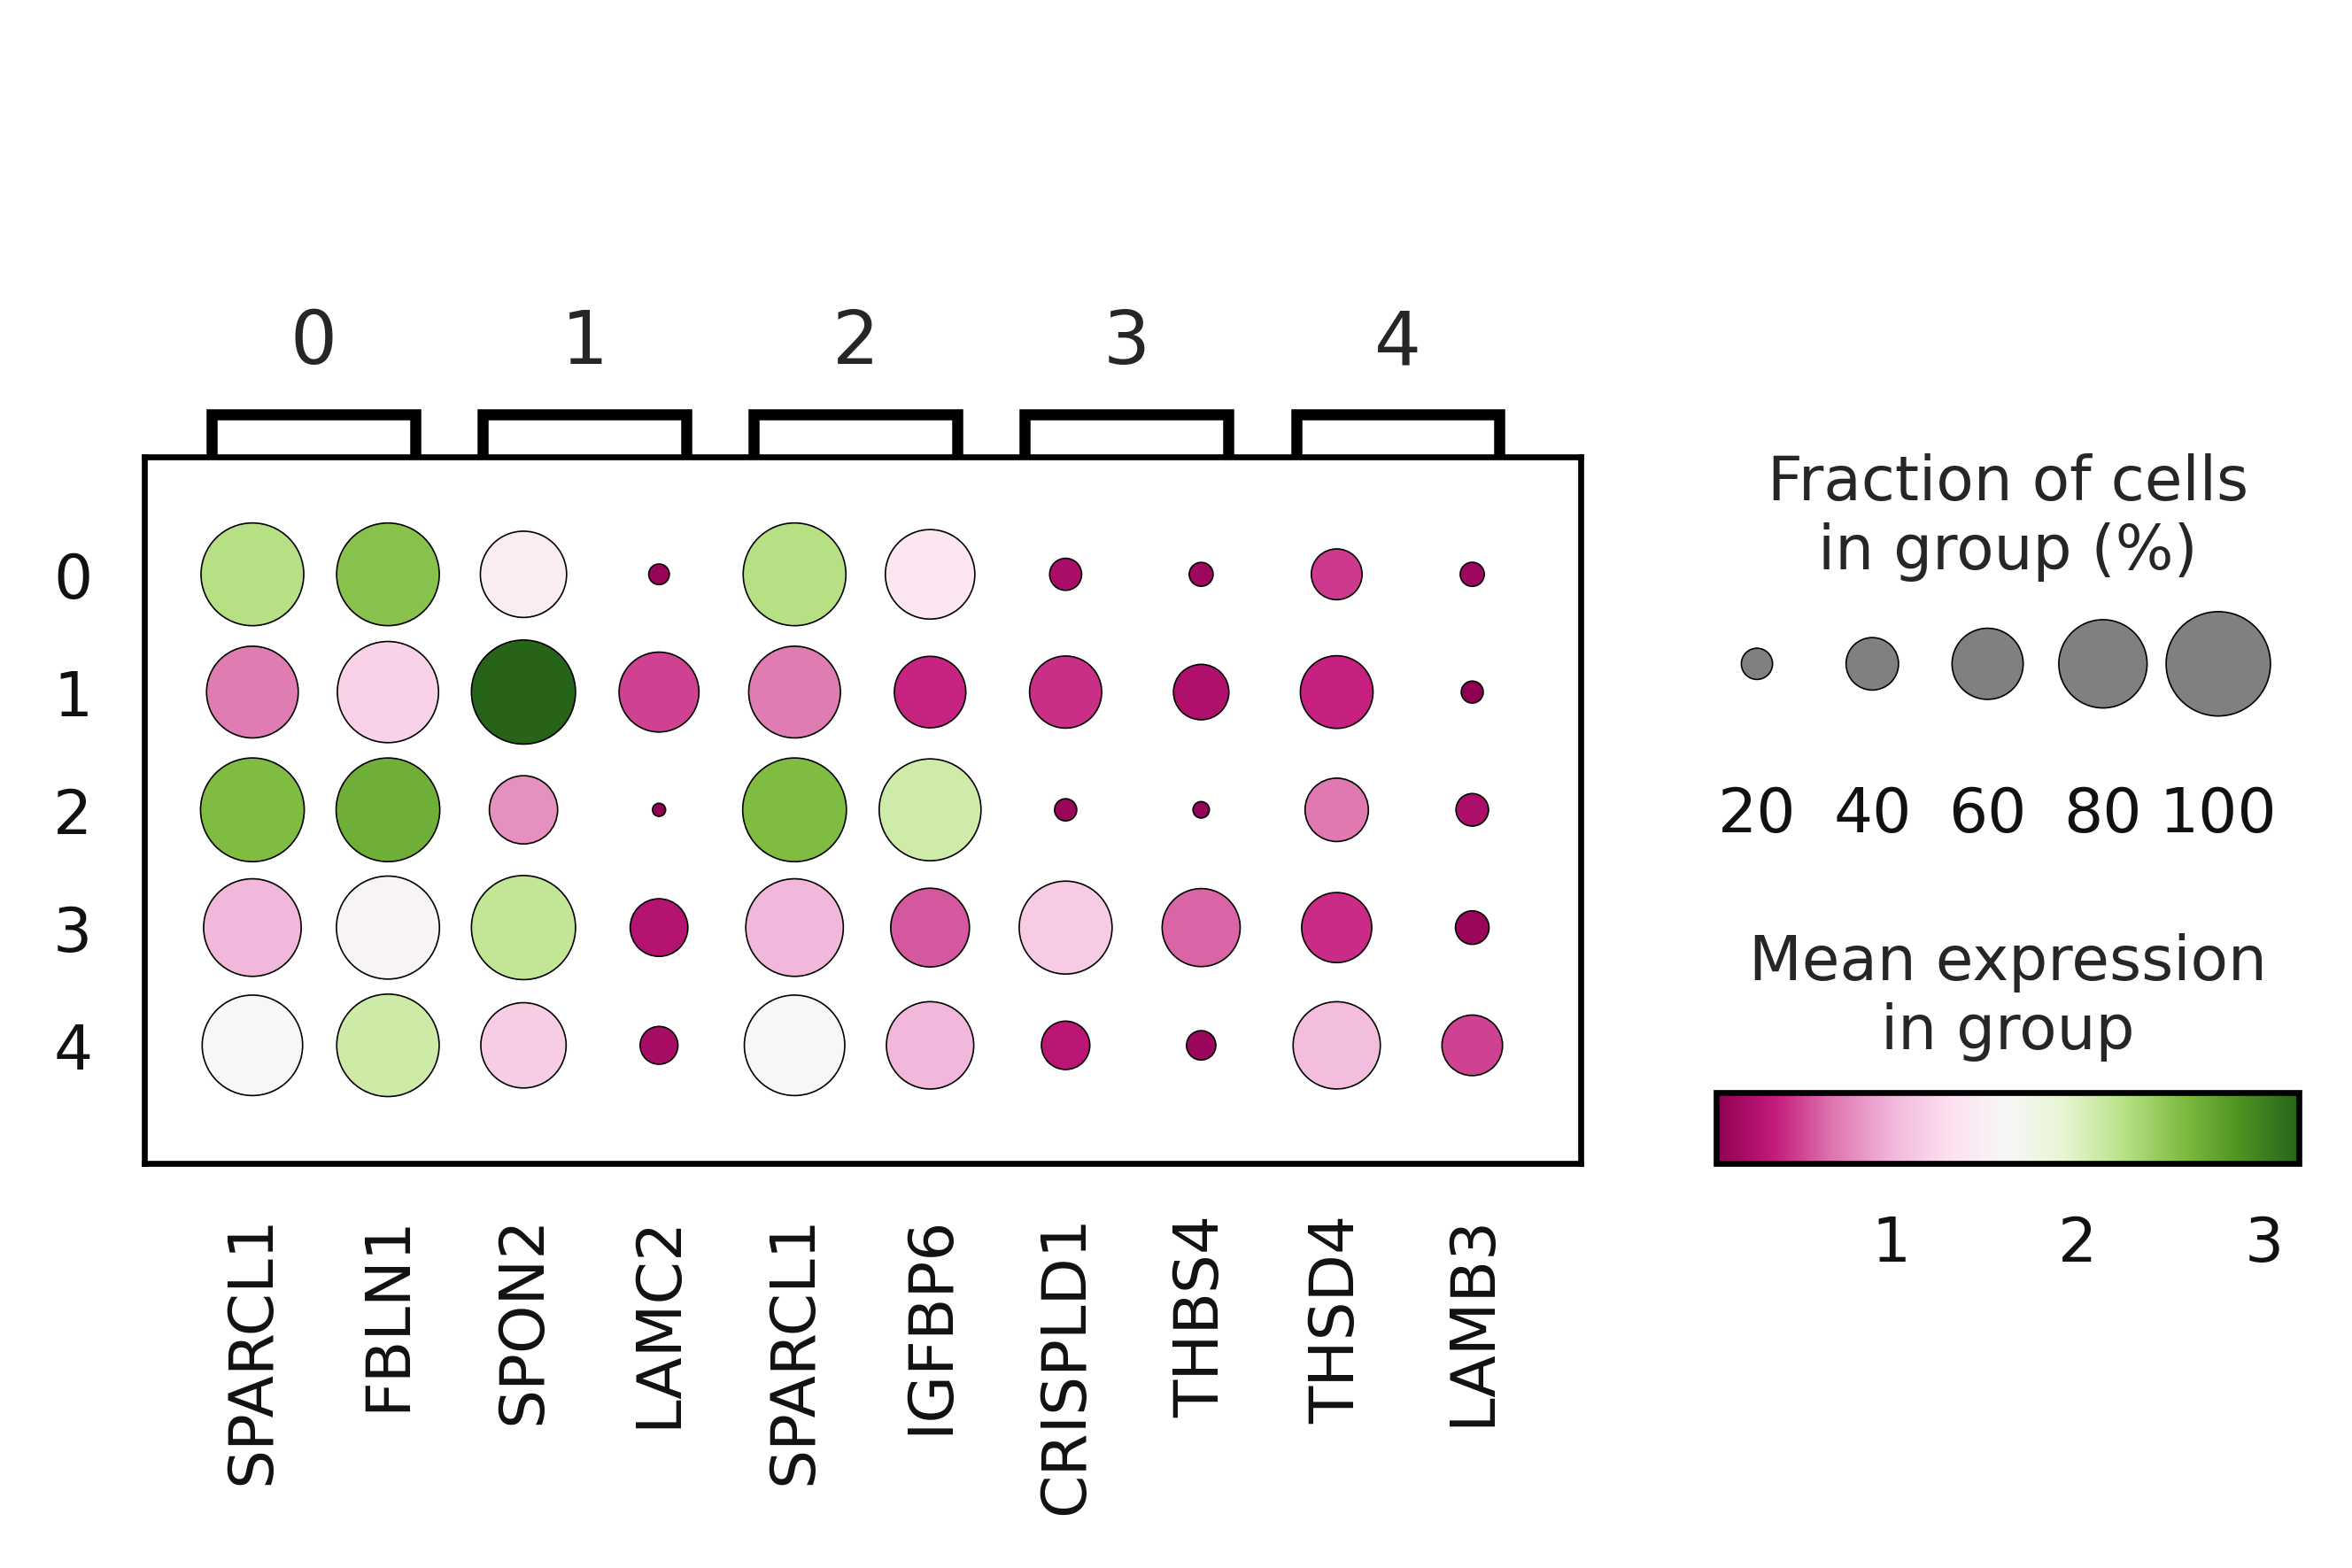

In [ ]:
adata_gp = filter_matrisome('ECM Glycoproteins')
plot_ranked_genes_per_cluster(adata_gp, '_GP.png',  'PiYG')

In [ ]:
adata_dict = map_kms_to_hires_image(adata_gp)
plot_hires_km(adata_dict, "PiYG", 'glycoproteins')

In [ ]:
p_df_gp = calc_all_percentages(adata_dict)
p_df_gp.to_excel('percentage_k_glyp.xlsx')

norm
[array([0.25, 0.01, 0.48, 0.  , 0.26])]
----
pc1
[array([0.25, 0.01, 0.48, 0.  , 0.26]), array([0.28, 0.33, 0.03, 0.12, 0.24])]
----
pc2
[array([0.25, 0.01, 0.48, 0.  , 0.26]), array([0.28, 0.33, 0.03, 0.12, 0.24]), array([0.01, 0.25, 0.01, 0.72, 0.01])]
----


In [ ]:
# Save km labels, pc1 = iac, pc2 = acc
adata_dict['norm'].obs.to_excel('gp_norm_km_labels.xlsx')
adata_dict['pc1'].obs.to_excel('gp_iac_km_labels.xlsx')
adata_dict['pc2'].obs.to_excel('gp_aac_km_labels.xlsx')


# Proteoglycans 

Image results will be saved in Proteoglycans_figures folder


In [ ]:
set_figure_dir('Proteoglycans')

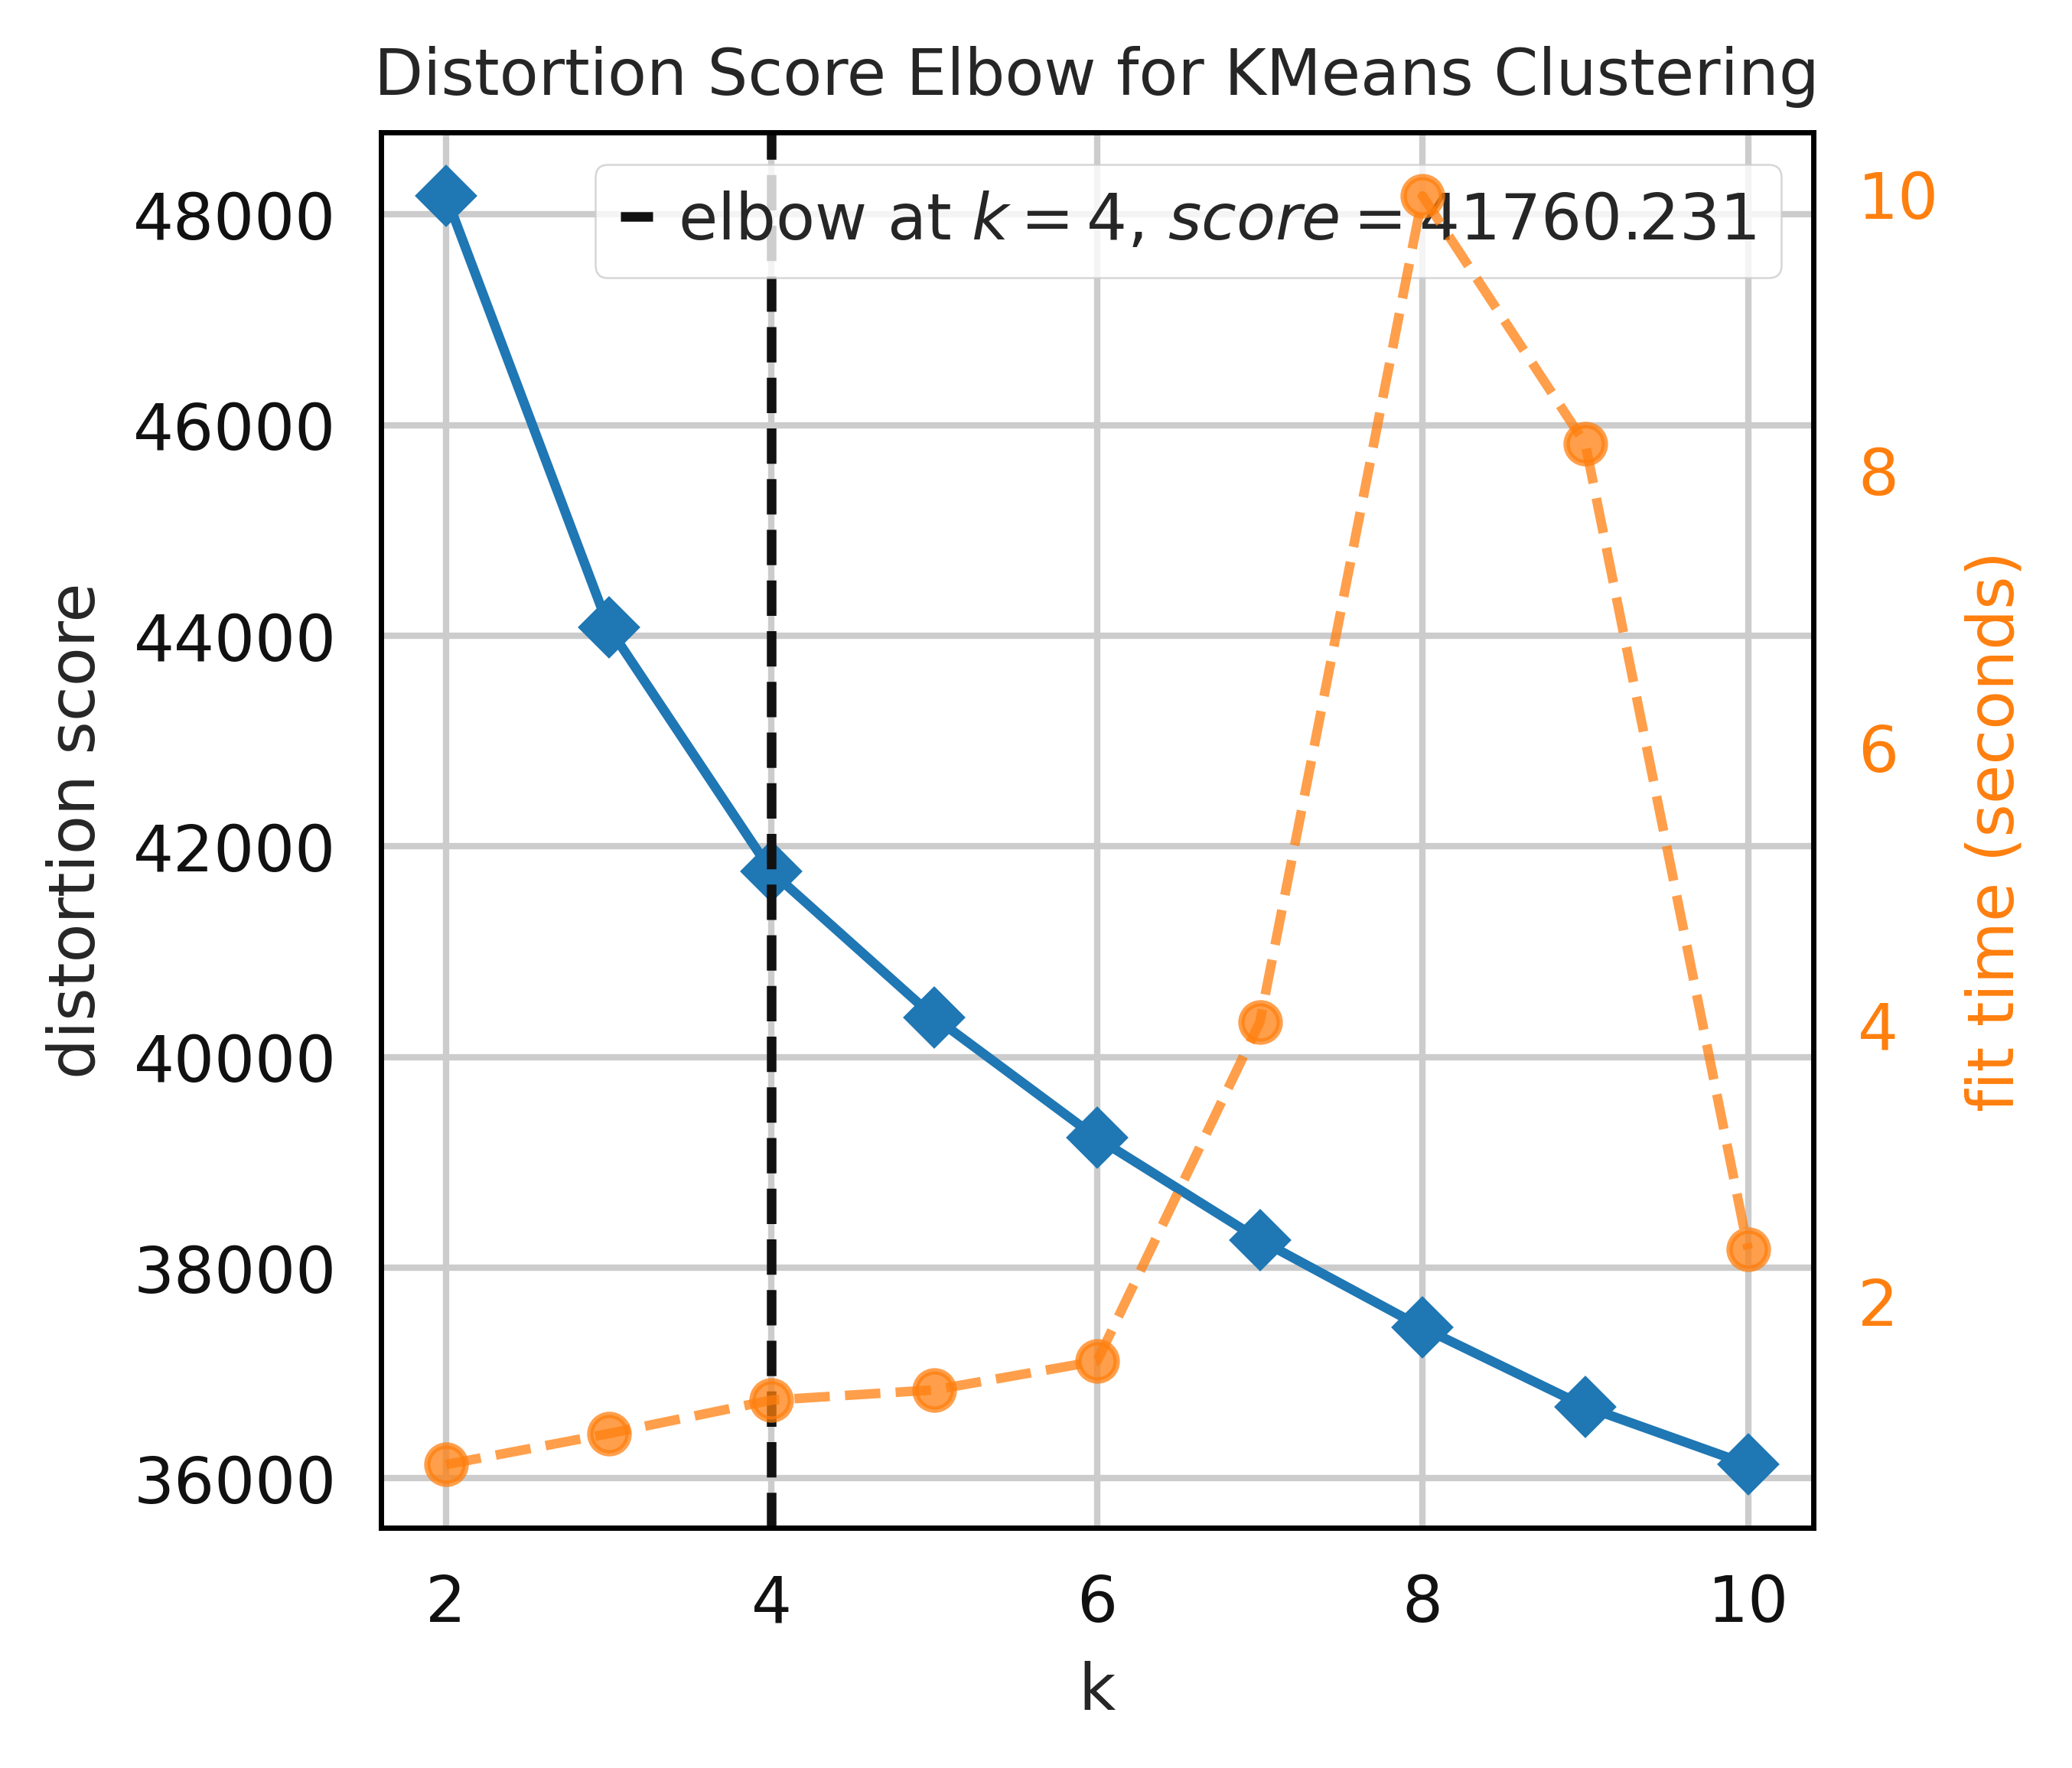

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if sys.path[0] == '':


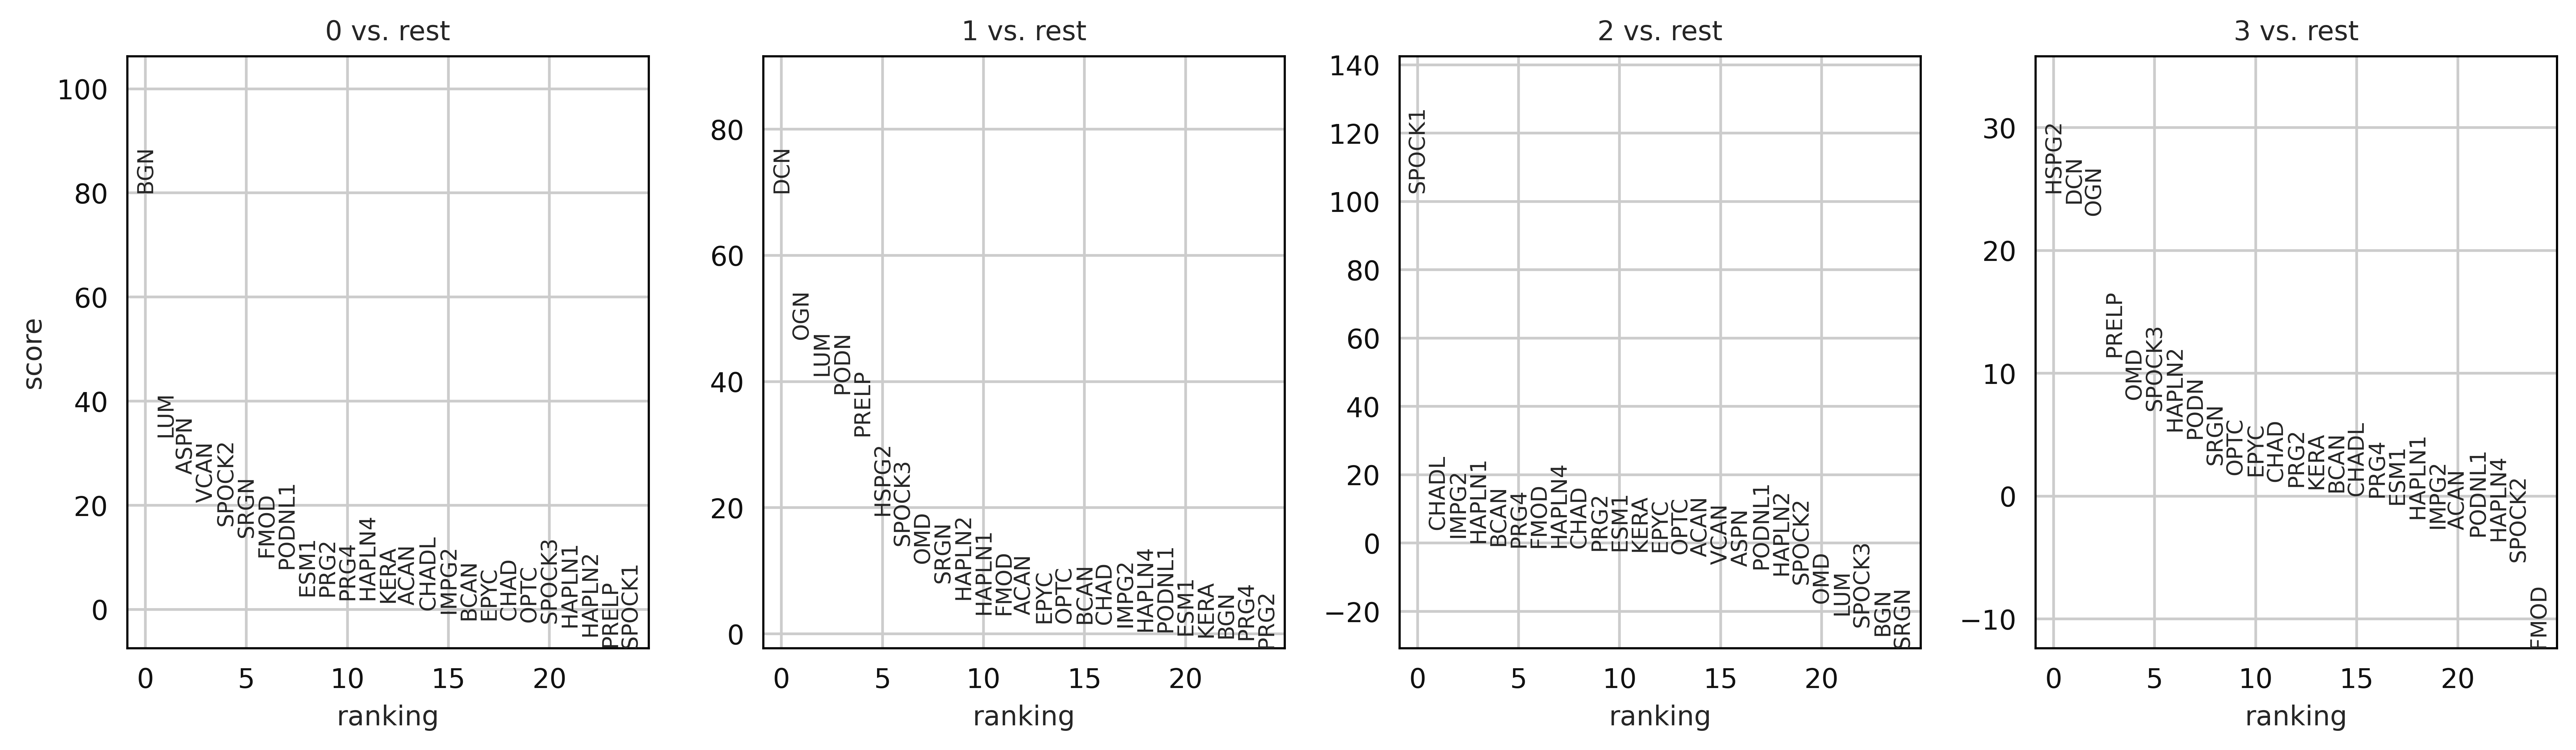

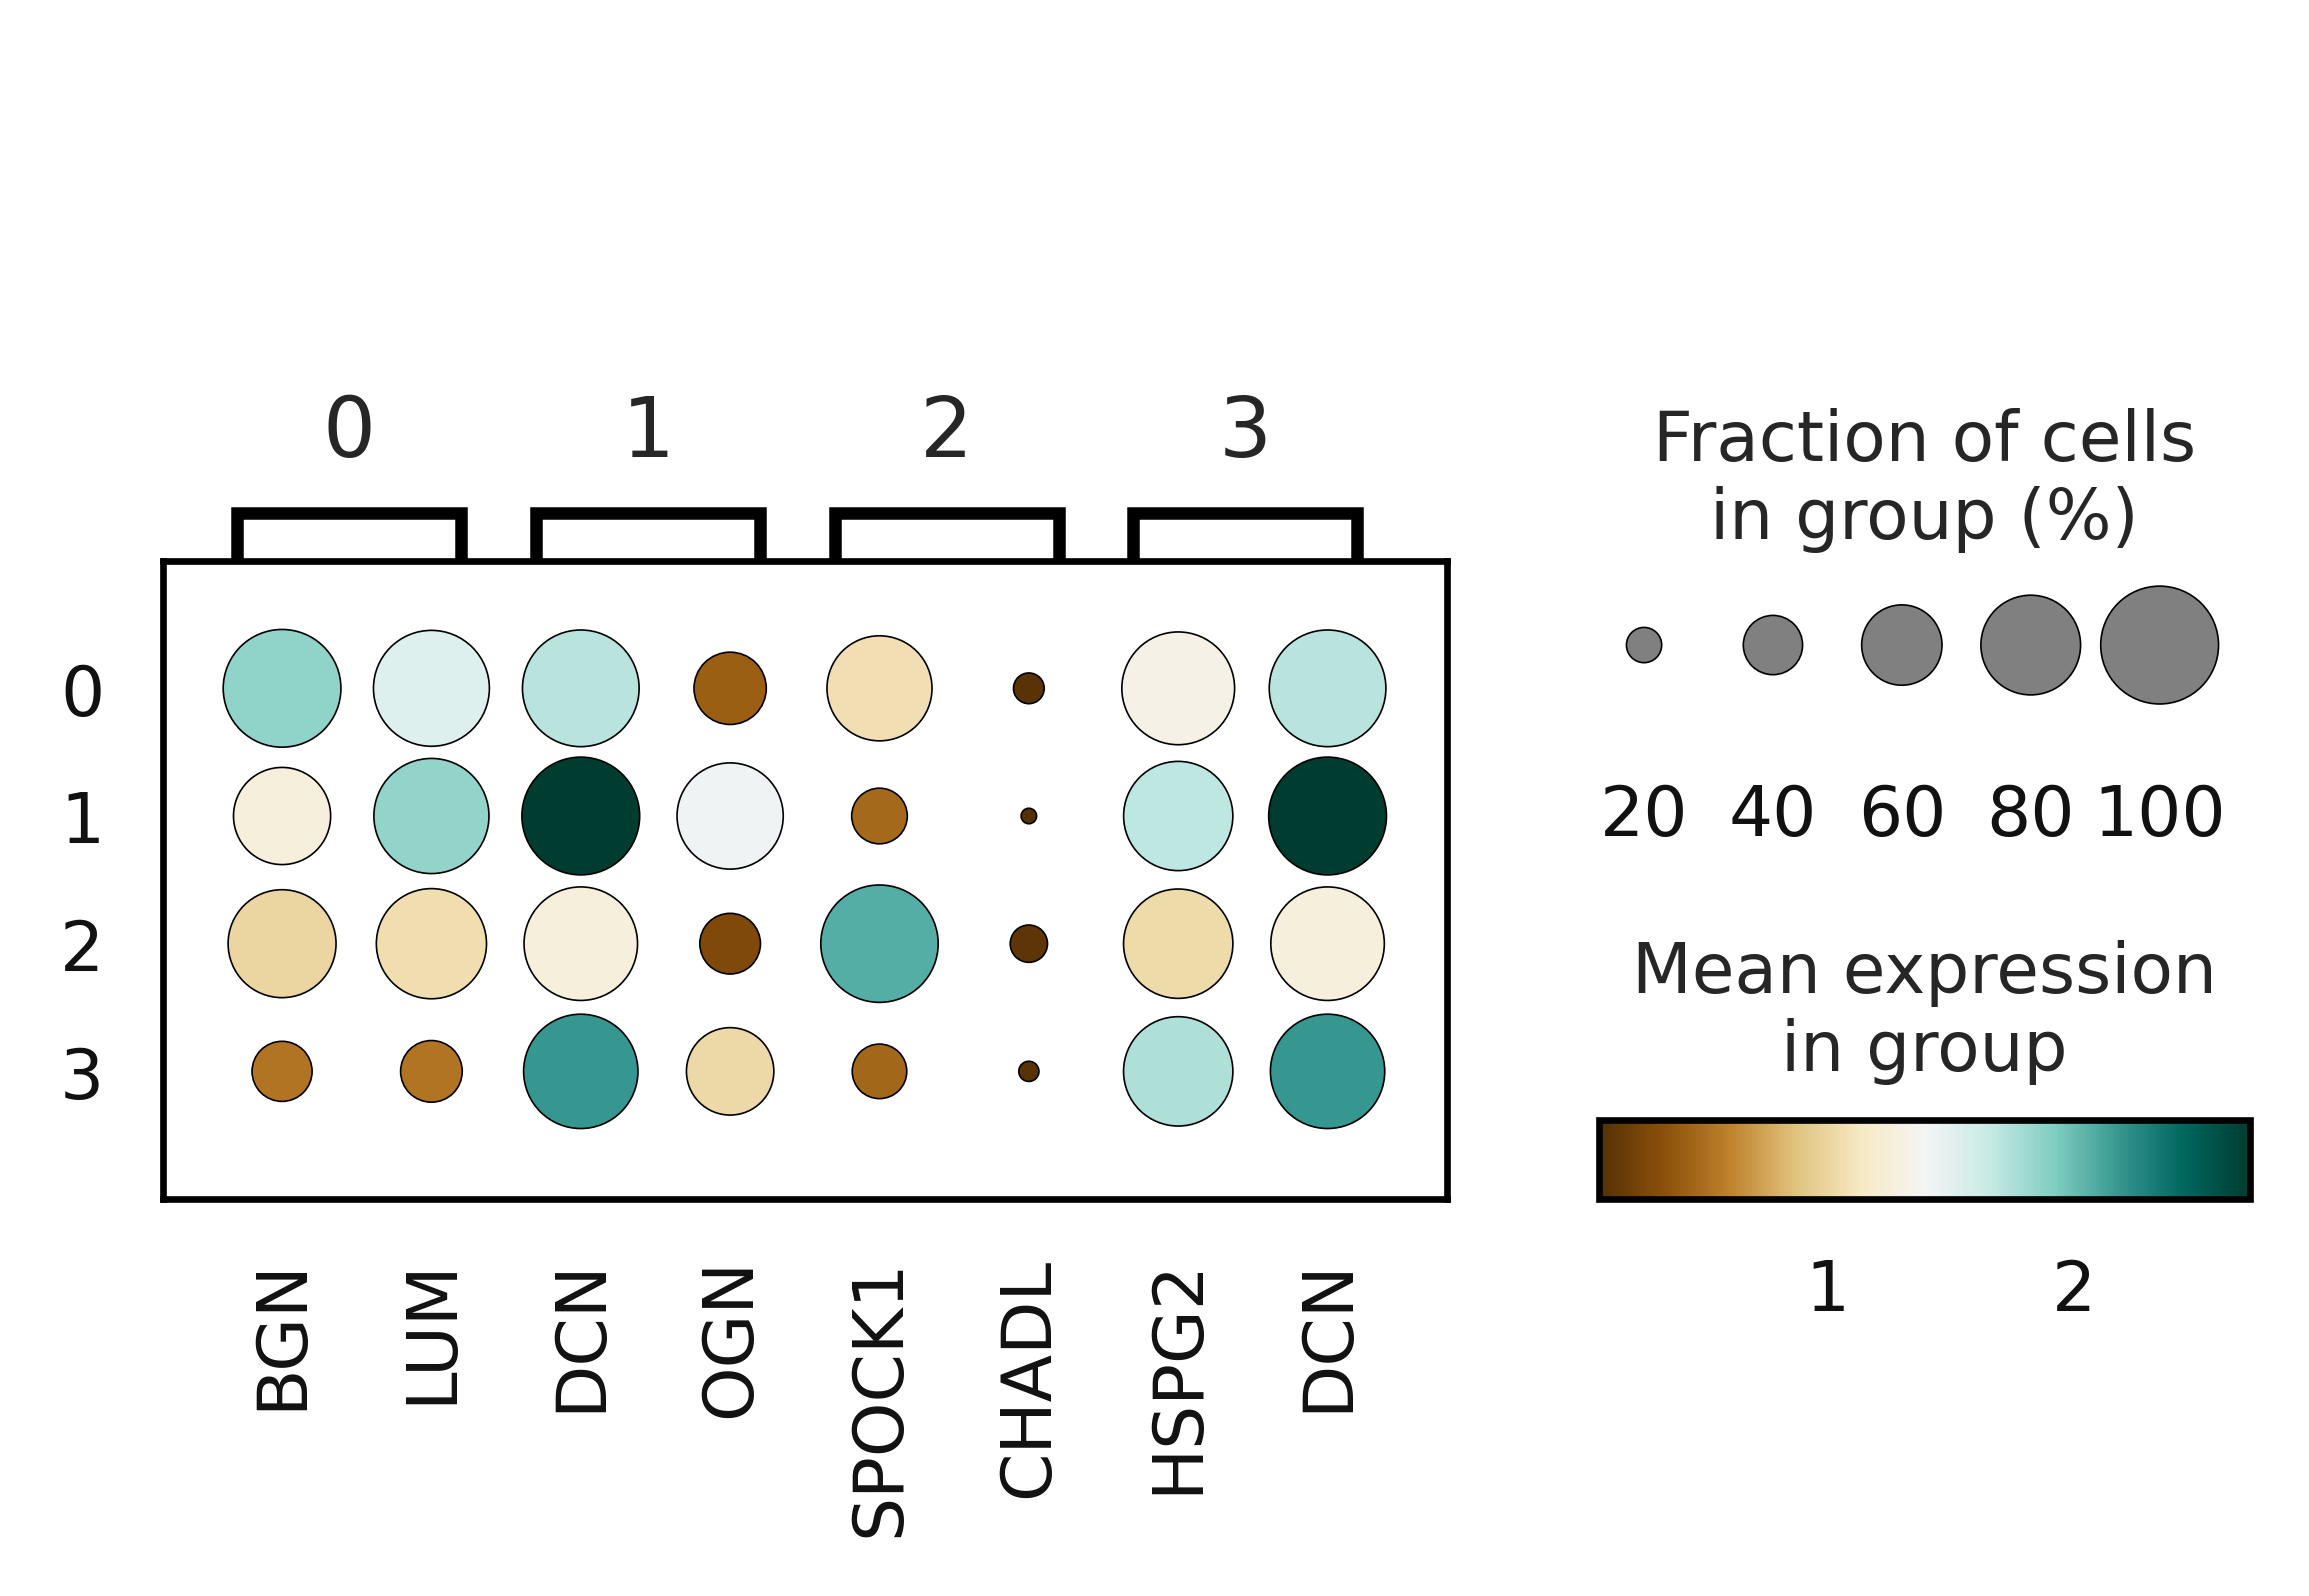

In [ ]:
adata_pg = filter_matrisome('Proteoglycans')
plot_ranked_genes_per_cluster(adata_pg, 'PG_dotplot.png', 'BrBG')

In [ ]:
adata_dict = map_kms_to_hires_image(adata_pg)
plot_hires_km(adata_dict, 'BrBG', 'proteoglycans')

In [ ]:
p_df_pg = calc_all_percentages(adata_dict)
p_df_pg.to_excel('percentage_k_pg.xlsx')

norm
[array([0.14, 0.41, 0.05, 0.4 ])]
----
pc1
[array([0.14, 0.41, 0.05, 0.4 ]), array([0.25, 0.1 , 0.45, 0.19])]
----
pc2
[array([0.14, 0.41, 0.05, 0.4 ]), array([0.25, 0.1 , 0.45, 0.19]), array([0.74, 0.02, 0.23, 0.01])]
----


In [ ]:
# Save km labels, pc1 = iac, pc2 = acc
adata_dict['norm'].obs.to_excel('pg_norm_km_labels.xlsx')
adata_dict['pc1'].obs.to_excel('pg_iac_km_labels.xlsx')
adata_dict['pc2'].obs.to_excel('pg_aac_km_labels.xlsx')

# Regulators

Image results saved in Regulators_figures folder


In [46]:
set_figure_dir('Regulators')

Image results saved in Regulators_figures folder


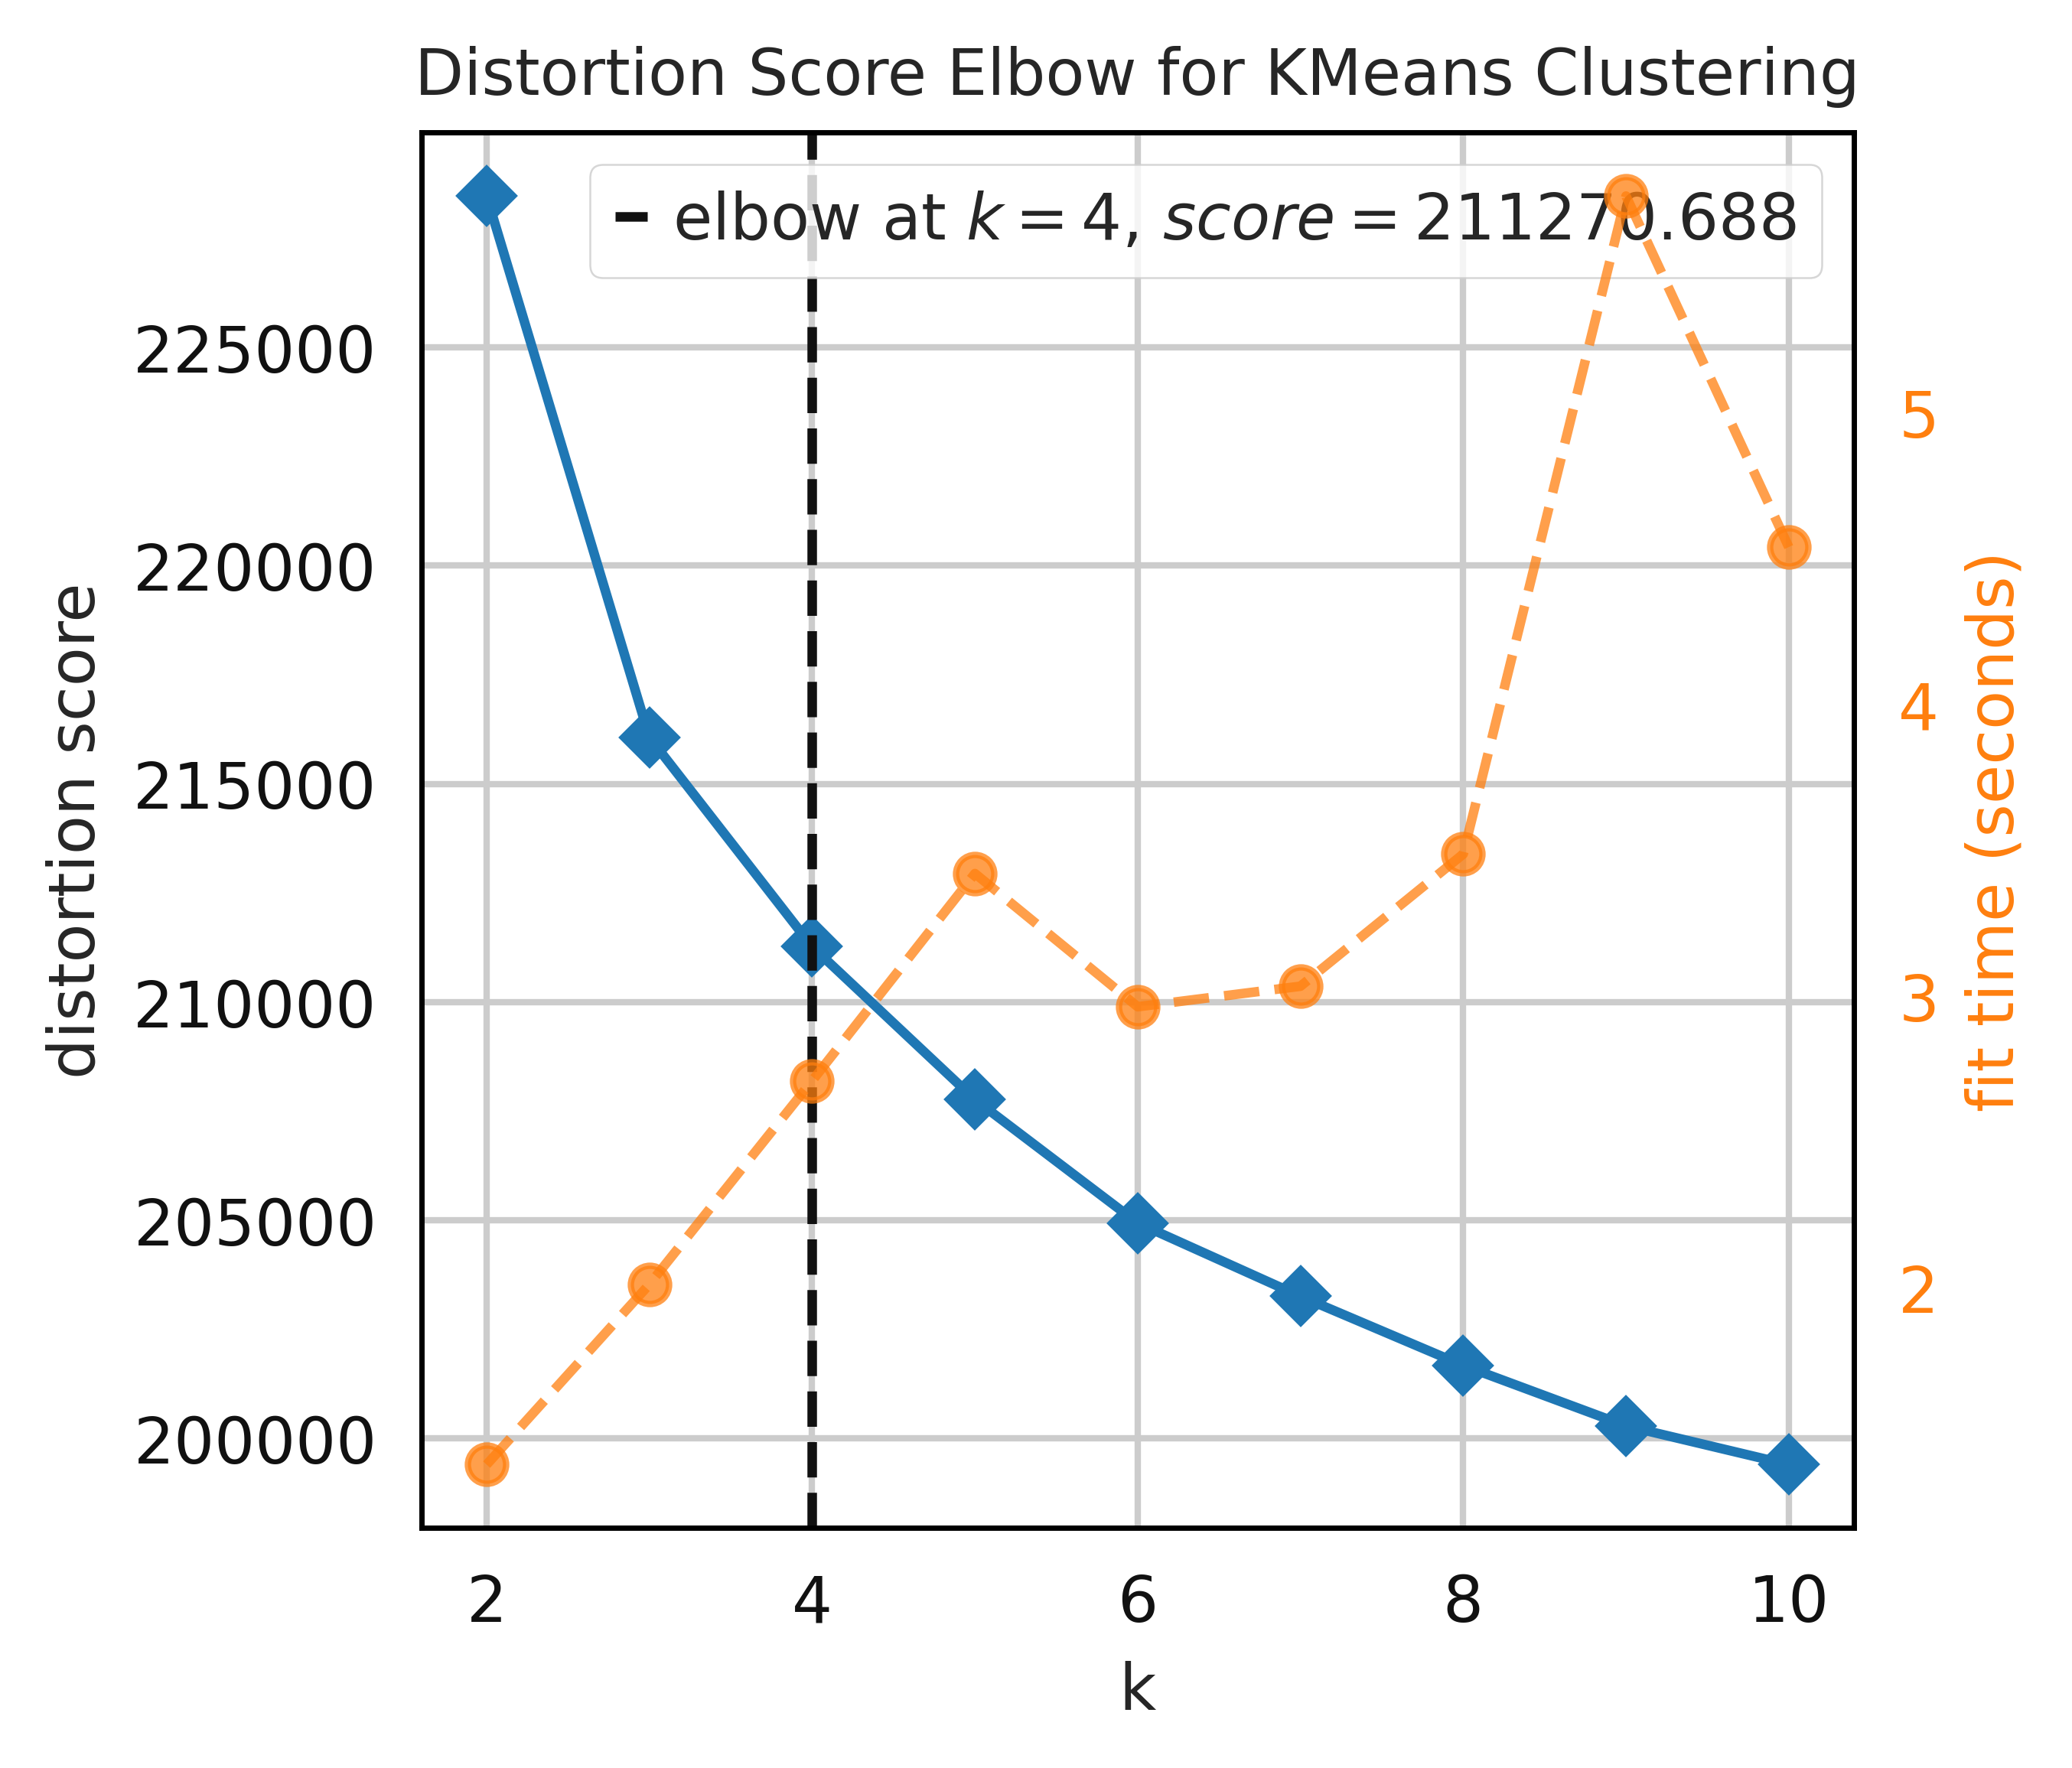

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


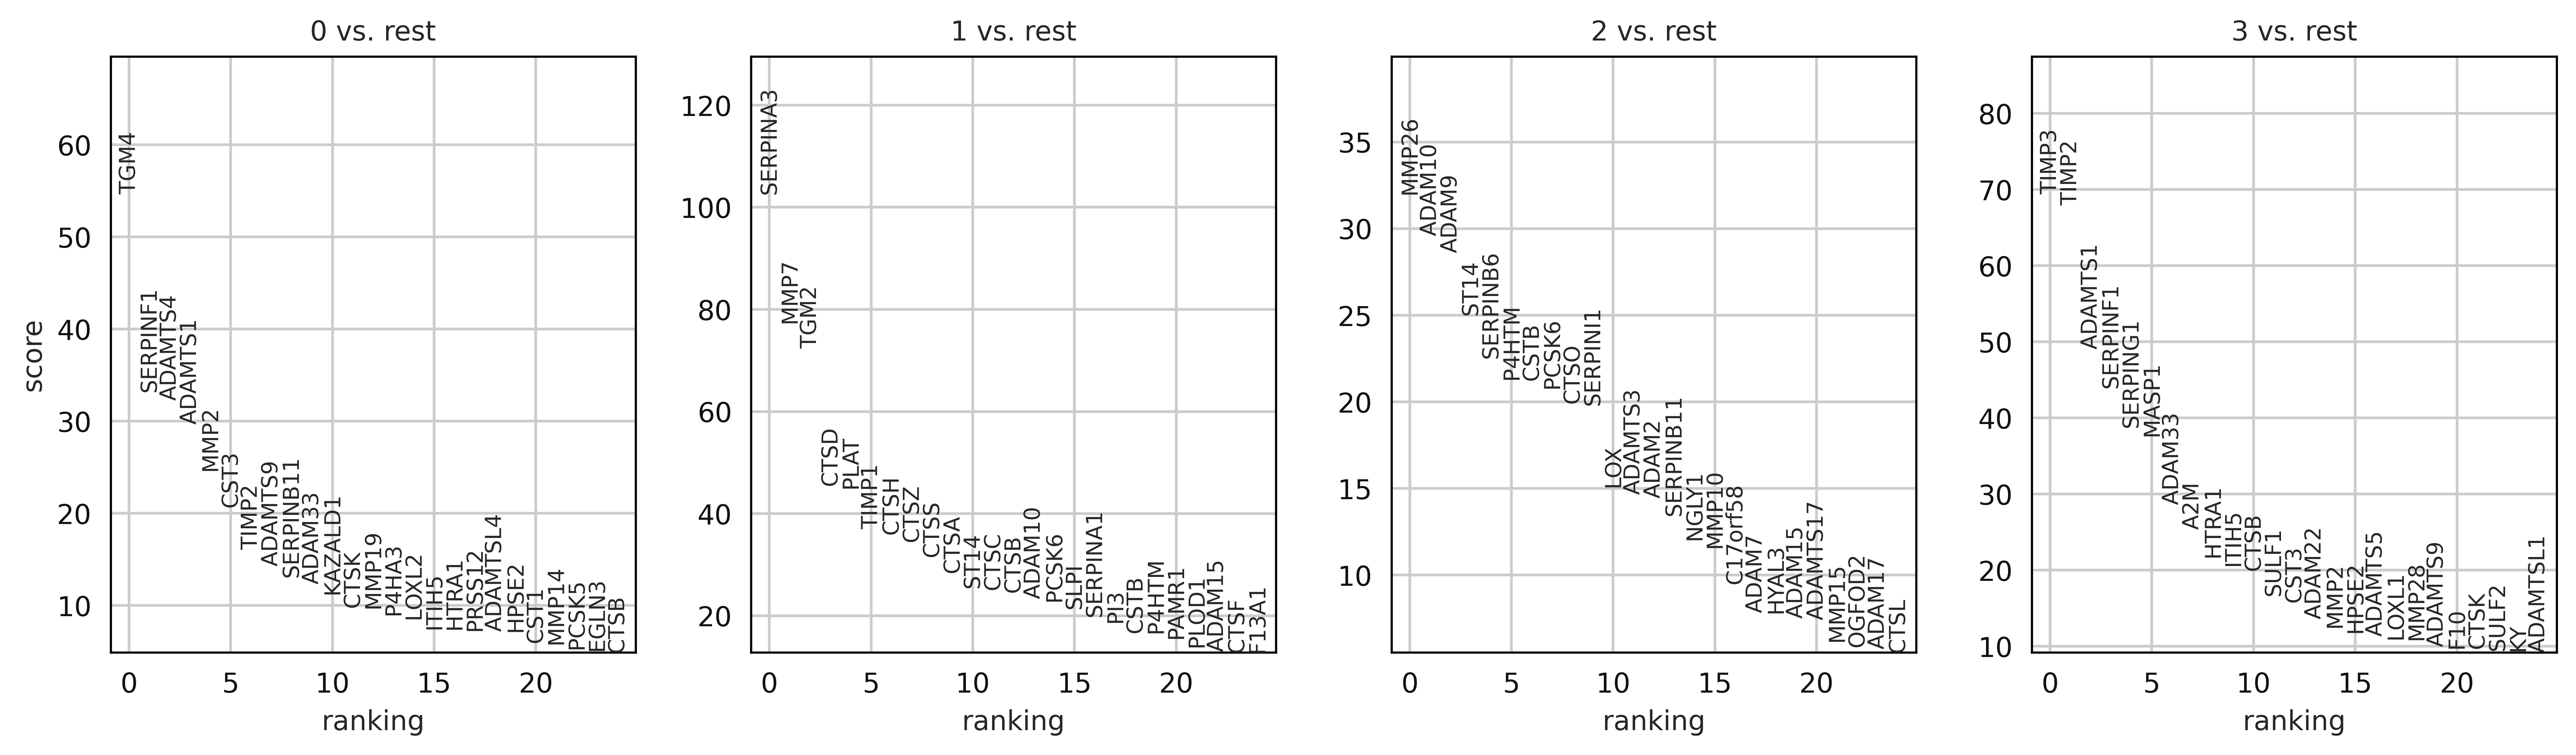

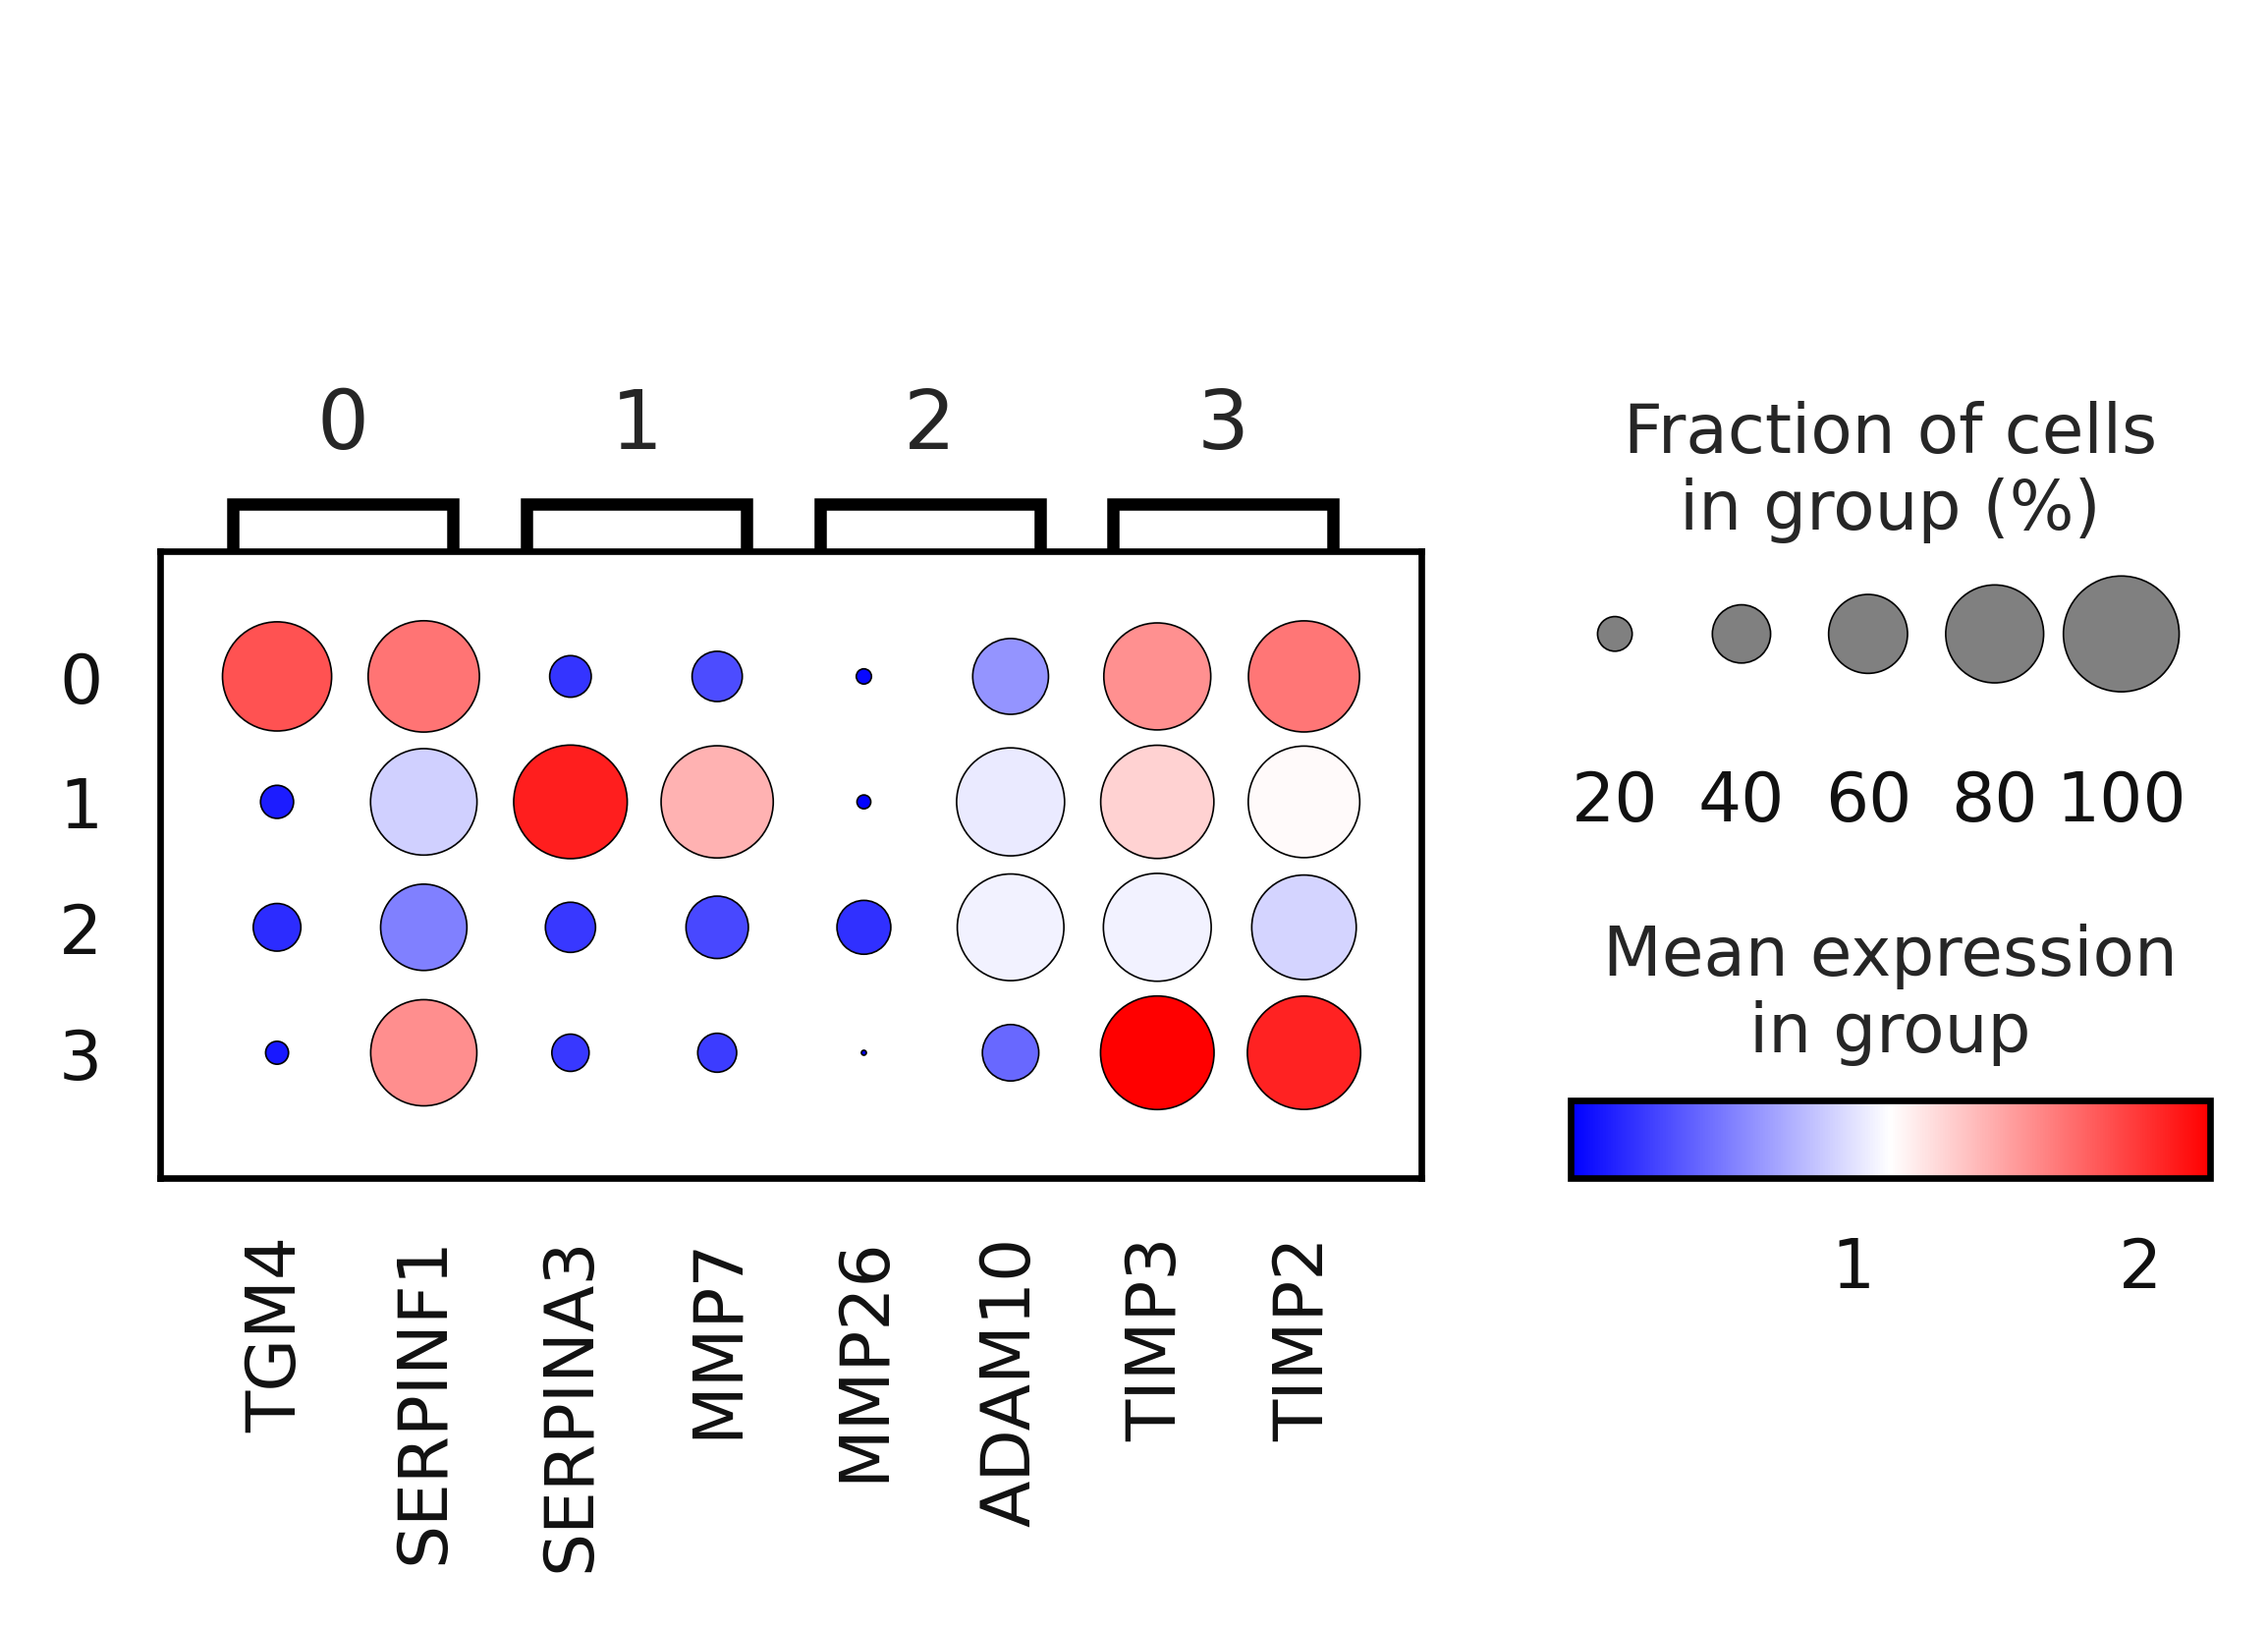

In [47]:
adata_rg = filter_matrisome('ECM Regulators')
plot_ranked_genes_per_cluster(adata_rg, 'dot_Reg.png', 'bwr')

In [48]:
adata_dict = map_kms_to_hires_image(adata_rg)
plot_hires_km(adata_dict, 'bwr', 'regulators')


In [50]:
# Save km labels, pc1 = iac, pc2 = acc
adata_dict['Norm'].obs.to_excel('reg_norm_km_labels.xlsx')
adata_dict['IAC'].obs.to_excel('reg_iac_km_labels.xlsx')
adata_dict['ACC'].obs.to_excel('reg_aac_km_labels.xlsx')


In [51]:
p_df = calc_all_percentages(adata_dict)
p_df.to_excel('regs_percentages.xlsx')

Norm
[array([0.04, 0.03, 0.1 , 0.83])]
----
IAC
[array([0.04, 0.03, 0.1 , 0.83]), array([0.26, 0.05, 0.49, 0.19])]
----
ACC
[array([0.04, 0.03, 0.1 , 0.83]), array([0.26, 0.05, 0.49, 0.19]), array([0.  , 0.74, 0.23, 0.02])]
----
